In [12]:
import os,sys,inspect
import os
import joblib
import tensorflow.compat.v1 as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
path_dataset = '/Users/liujiaoyang/tensorflow/MGCNN/Data/Synthetic_Netflix/synthetic_netflix.mat'

In [3]:
# auxiliary functions:

# import matlab files in python
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

In [4]:
#loading of the required matrices
M = load_matlab_file(path_dataset, 'M')
Otraining = load_matlab_file(path_dataset, 'Otraining')
Otest = load_matlab_file(path_dataset, 'Otest')
Wrow = load_matlab_file(path_dataset, 'Wrow') #sparse
Wcol = load_matlab_file(path_dataset, 'Wcol') #sparse

In [5]:
np.random.seed(0)
pos_tr_samples = np.where(Otraining)

num_tr_samples = len(pos_tr_samples[0])
list_idx = list(range(num_tr_samples))
np.random.shuffle(list_idx)
idx_data = list_idx[:num_tr_samples//2]
idx_train = list_idx[num_tr_samples//2:]

pos_data_samples = (pos_tr_samples[0][idx_data], pos_tr_samples[1][idx_data])
pos_tr_samples = (pos_tr_samples[0][idx_train], pos_tr_samples[1][idx_train])

Odata = np.zeros(M.shape)
Otraining = np.zeros(M.shape)

for k in range(len(pos_data_samples[0])):
    Odata[pos_data_samples[0][k], pos_data_samples[1][k]] = 1
    
for k in range(len(pos_tr_samples[0])):
    Otraining[pos_tr_samples[0][k], pos_tr_samples[1][k]] = 1
    
print ('Num data samples: %d' % (np.sum(Odata),))
print ('Num train samples: %d' % (np.sum(Otraining),))
print ('Num train+data samples: %d' % (np.sum(Odata+Otraining),))

Num data samples: 2250
Num train samples: 2250
Num train+data samples: 4500


In [6]:
#computation of the normalized laplacians
Lrow = sp.csgraph.laplacian(Wrow, normed=True) 
Lcol = sp.csgraph.laplacian(Wcol, normed=True) 

In [7]:
#apply SVD initially for detecting the main components of our initialization
U, s, V = np.linalg.svd(Odata*M, full_matrices=0)

print (U.shape)
print (s.shape)
print (V.shape)

(150, 150)
(150,)
(150, 200)


In [8]:
rank_W_H = 15
partial_s = s[:rank_W_H]
partial_S_sqrt = np.diag(np.sqrt(partial_s))
initial_W = np.dot(U[:, :rank_W_H], partial_S_sqrt)
initial_H = np.dot(partial_S_sqrt, V[:rank_W_H, :]).T

print (initial_W.shape)
print (initial_H.shape)

(150, 15)
(200, 15)


Original training matrix
Reconstructed training matrix


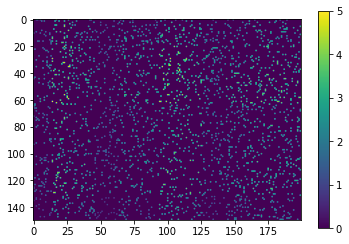

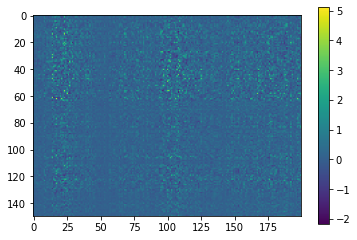

In [9]:
print ('Original training matrix')
plt.figure()
plt.imshow(Odata*M)
plt.colorbar()

print ('Reconstructed training matrix')
plt.figure()
plt.imshow(np.dot(initial_W, initial_H.T))
plt.colorbar()

In [18]:
class Train_test_matrix_completion:
    
    """
    The neural network model.
    """
    
    def frobenius_norm(self, tensor):
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    def mono_conv(self, list_lap, ord_conv, A, W, b):
        
        feat = []
        #collect features
        for k in range(ord_conv):
            c_lap = list_lap[k] 
                                                     
            #dense implementation
            c_feat = tf.matmul(c_lap, A, a_is_sparse=False)
            feat.append(c_feat)
            
        all_feat = tf.concat(feat, 1)
        conv_feat = tf.matmul(all_feat, W) + b
        conv_feat = tf.nn.relu(conv_feat)
        
        return conv_feat
                
    def compute_cheb_polynomials(self, L, ord_cheb, list_cheb):
        for k in range(ord_cheb):
            if (k==0):
                list_cheb.append(tf.cast(tf.diag(tf.ones([tf.shape(L)[0],])), 'float32'))
            elif (k==1):
                list_cheb.append(tf.cast(L, 'float32'))
            else:
                list_cheb.append(2*tf.matmul(L, list_cheb[k-1])  - list_cheb[k-2])  
    
    def __init__(self, M, Lr, Lc, Odata, Otraining, Otest, initial_W, initial_H,
                 order_chebyshev_col = 5, order_chebyshev_row = 5,
                 num_iterations = 10, gamma=1.0, learning_rate=1e-4, idx_gpu = '/gpu:2'):
        
        #order of the spectral filters
        self.ord_col = order_chebyshev_col 
        self.ord_row = order_chebyshev_row
        self.num_iterations = num_iterations
        self.n_conv_feat = 32
        
        with tf.Graph().as_default() as g:
                tf.logging.set_verbosity(tf.logging.ERROR)
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                    
                        #loading of the laplacians
                        self.Lr = tf.constant(Lr.astype('float32'))
                        self.Lc = tf.constant(Lc.astype('float32'))
                        
                        self.norm_Lr = self.Lr - tf.diag(tf.ones([Lr.shape[0], ]))
                        self.norm_Lc = self.Lc - tf.diag(tf.ones([Lc.shape[0], ]))
                        
                        #compute all chebyshev polynomials a priori
                        self.list_row_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lr, self.ord_row, self.list_row_cheb_pol)
                        self.list_col_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lc, self.ord_col, self.list_col_cheb_pol)
                        
                        #definition of constant matrices
                        self.M = tf.constant(M, dtype=tf.float32)
                        self.Odata = tf.constant(Odata, dtype=tf.float32)
                        self.Otraining = tf.constant(Otraining, dtype=tf.float32) #training mask
                        self.Otest = tf.constant(Otest, dtype=tf.float32) #test mask
                         
                        ##################################definition of the NN variables#####################################
                        
                        #definition of the weights for extracting the global features
                        self.W_conv_W = tf.get_variable("W_conv_W", shape=[self.ord_col*initial_W.shape[1], self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv_W = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.W_conv_H = tf.get_variable("W_conv_H", shape=[self.ord_row*initial_W.shape[1], self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv_H = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #recurrent N parameters
                        self.W_f_u = tf.get_variable("W_f_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i_u = tf.get_variable("W_i_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o_u = tf.get_variable("W_o_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c_u = tf.get_variable("W_c_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f_u = tf.get_variable("U_f_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i_u = tf.get_variable("U_i_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o_u = tf.get_variable("U_o_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c_u = tf.get_variable("U_c_u", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c_u = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        self.W_f_m = tf.get_variable("W_f_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i_m = tf.get_variable("W_i_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o_m = tf.get_variable("W_o_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c_m = tf.get_variable("W_c_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f_m = tf.get_variable("U_f_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i_m = tf.get_variable("U_i_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o_m = tf.get_variable("U_o_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c_m = tf.get_variable("U_c_m", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c_m = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #output parameters
                        self.W_out_W = tf.get_variable("W_out_W", shape=[self.n_conv_feat, initial_W.shape[1]], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out_W = tf.Variable(tf.zeros([initial_W.shape[1],]))
                        self.W_out_H = tf.get_variable("W_out_H", shape=[self.n_conv_feat, initial_H.shape[1]], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out_H = tf.Variable(tf.zeros([initial_H.shape[1],]))
                        
                        #########definition of the NN
                        #definition of W and H
                        self.W = tf.constant(initial_W.astype('float32'))
                        self.H = tf.constant(initial_H.astype('float32'))
                        
                        self.X = tf.matmul(self.W, self.H, transpose_b=True) #we may initialize it at random here
                        self.list_X = list()
                        self.list_X.append(tf.identity(self.X))
                        
                        #RNN
                        self.h_u = tf.zeros([M.shape[0], self.n_conv_feat])
                        self.c_u = tf.zeros([M.shape[0], self.n_conv_feat])
                        self.h_m = tf.zeros([M.shape[1], self.n_conv_feat])
                        self.c_m = tf.zeros([M.shape[1], self.n_conv_feat])
                        
                        
                        for k in range(self.num_iterations):
                            #extraction of global features vectors
                            self.final_feat_users = self.mono_conv(self.list_row_cheb_pol, self.ord_row, self.W, self.W_conv_W, self.b_conv_W)
                            self.final_feat_movies = self.mono_conv(self.list_col_cheb_pol, self.ord_col, self.H, self.W_conv_H, self.b_conv_H)
                            
                            #here we have to split the features between users and movies LSTMs
                            
                            #users RNN
                            self.f_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_f_u) + tf.matmul(self.h_u, self.U_f_u) + self.b_f_u)
                            self.i_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_i_u) + tf.matmul(self.h_u, self.U_i_u) + self.b_i_u)
                            self.o_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_o_u) + tf.matmul(self.h_u, self.U_o_u) + self.b_o_u)
                            
                            self.update_c_u = tf.sigmoid(tf.matmul(self.final_feat_users, self.W_c_u) + tf.matmul(self.h_u, self.U_c_u) + self.b_c_u)
                            self.c_u = tf.multiply(self.f_u, self.c_u) + tf.multiply(self.i_u, self.update_c_u)
                            self.h_u = tf.multiply(self.o_u, tf.sigmoid(self.c_u))
                            
                            #movies RNN
                            self.f_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_f_m) + tf.matmul(self.h_m, self.U_f_m) + self.b_f_m)
                            self.i_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_i_m) + tf.matmul(self.h_m, self.U_i_m) + self.b_i_m)
                            self.o_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_o_m) + tf.matmul(self.h_m, self.U_o_m) + self.b_o_m)
                            
                            self.update_c_m = tf.sigmoid(tf.matmul(self.final_feat_movies, self.W_c_m) + tf.matmul(self.h_m, self.U_c_m) + self.b_c_m)
                            self.c_m = tf.multiply(self.f_m, self.c_m) + tf.multiply(self.i_m, self.update_c_m)
                            self.h_m = tf.multiply(self.o_m, tf.sigmoid(self.c_m))
                            
                            #compute update of matrix X
                            self.delta_W = tf.tanh(tf.matmul(self.c_u, self.W_out_W) + self.b_out_W) #N x rank_W_H
                            self.delta_H = tf.tanh(tf.matmul(self.c_m, self.W_out_H) + self.b_out_H) #M x rank_W_H
                            
                            self.W += self.delta_W
                            self.H += self.delta_H
                        
                            self.X = tf.matmul(self.W, self.H, transpose_b=True)
                            self.list_X.append(tf.identity(tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])))
                        self.X = tf.matmul(self.W, self.H, transpose_b=True)
                        #########loss definition
                        
                        #computation of the accuracy term
                        self.norm_X = 1+4*(self.X-tf.reduce_min(self.X))/(tf.reduce_max(self.X-tf.reduce_min(self.X)))
                        frob_tensor = tf.multiply(self.Otraining + self.Odata, self.norm_X - M)
                        self.loss_frob = tf.square(self.frobenius_norm(frob_tensor))/np.sum(Otraining+Odata)
                        
                        #computation of the regularization terms
                        trace_col_tensor = tf.matmul(tf.matmul(self.X, self.Lc), self.X, transpose_b=True)
                        self.loss_trace_col = tf.trace(trace_col_tensor)
                        trace_row_tensor = tf.matmul(tf.matmul(self.X, self.Lr, transpose_a=True), self.X)
                        self.loss_trace_row = tf.trace(trace_row_tensor)
                        
                        #training loss definition
                        self.loss = self.loss_frob + (gamma/2)*(self.loss_trace_col + self.loss_trace_row)
                        
                        #test loss definition
                        self.predictions = tf.multiply(self.Otest, self.norm_X - self.M)
                        self.predictions_error = self.frobenius_norm(self.predictions)

                        #definition of the solver
                        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
                        
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad], 0))

                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.initialize_all_variables()
                        self.session.run(init)

In [19]:
ord_col = 5
ord_row = 5

learning_obj = Train_test_matrix_completion(M, Lrow.toarray(), Lcol.toarray(), Odata, Otraining, Otest, 
                                            initial_W, initial_H,
                                            order_chebyshev_col = ord_col, 
                                            order_chebyshev_row = ord_row, 
                                            gamma=1e-10,
                                            learning_rate=1e-3)

num_iter_test = 10
num_total_iter_training = 50000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_test_pred_error = list()
list_predictions = list()
list_X = list()

list_training_times = list()
list_test_times = list()
list_grad_X = list()

list_X_evolutions = list()

In [20]:
num_iter = 0
for k in range(num_iter, num_total_iter_training):

    tic = time.time()
    _, current_training_loss, norm_grad, X_grad = learning_obj.session.run([learning_obj.optimizer, learning_obj.loss, 
                                                                                        learning_obj.norm_grad, learning_obj.var_grad]) 
    training_time = time.time() - tic

    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    list_training_times.append(training_time)
        
    if (np.mod(num_iter, num_iter_test)==0):
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print (msg)
            
        #Test Code
        tic = time.time()
        pred_error, preds, X = learning_obj.session.run([learning_obj.predictions_error, learning_obj.predictions,
                                                                             learning_obj.norm_X]) 
        c_X_evolutions = learning_obj.session.run(learning_obj.list_X)
        list_X_evolutions.append(c_X_evolutions)

        test_time = time.time() - tic

        list_test_pred_error.append(pred_error)
        list_X.append(X)
        list_test_times.append(test_time)
        msg =  "[TST] iter = %03i, cost = %3.2e (%3.2es)" % (num_iter, list_test_pred_error[-1], test_time)
        print (msg)
            
    num_iter += 1

[TRN] iter = 000, cost = 7.97e-01, |grad| = 9.54e+00 (1.91e+00s)
[TST] iter = 000, cost = 6.72e+01 (6.54e-01s)
[TRN] iter = 010, cost = 6.39e-01, |grad| = 1.06e+00 (1.27e-02s)
[TST] iter = 010, cost = 5.41e+01 (8.00e-03s)
[TRN] iter = 020, cost = 5.79e-01, |grad| = 4.58e-01 (1.10e-02s)
[TST] iter = 020, cost = 5.17e+01 (7.43e-03s)
[TRN] iter = 030, cost = 5.21e-01, |grad| = 9.74e-01 (8.72e-03s)
[TST] iter = 030, cost = 4.89e+01 (4.98e-03s)
[TRN] iter = 040, cost = 4.41e-01, |grad| = 8.27e-01 (8.23e-03s)
[TST] iter = 040, cost = 4.48e+01 (4.84e-03s)
[TRN] iter = 050, cost = 3.42e-01, |grad| = 1.37e+00 (8.65e-03s)
[TST] iter = 050, cost = 3.96e+01 (4.79e-03s)
[TRN] iter = 060, cost = 1.93e-01, |grad| = 7.37e-01 (9.37e-03s)
[TST] iter = 060, cost = 3.00e+01 (5.58e-03s)
[TRN] iter = 070, cost = 1.07e-01, |grad| = 4.43e-01 (8.22e-03s)
[TST] iter = 070, cost = 2.27e+01 (4.92e-03s)
[TRN] iter = 080, cost = 7.80e-02, |grad| = 5.24e-01 (8.40e-03s)
[TST] iter = 080, cost = 1.94e+01 (5.00e-03s)
[

[TRN] iter = 750, cost = 3.83e-02, |grad| = 1.14e-01 (8.52e-03s)
[TST] iter = 750, cost = 1.39e+01 (5.47e-03s)
[TRN] iter = 760, cost = 3.81e-02, |grad| = 3.63e-02 (9.57e-03s)
[TST] iter = 760, cost = 1.38e+01 (5.78e-03s)
[TRN] iter = 770, cost = 3.78e-02, |grad| = 1.81e-01 (9.74e-03s)
[TST] iter = 770, cost = 1.38e+01 (5.47e-03s)
[TRN] iter = 780, cost = 3.77e-02, |grad| = 2.87e-01 (1.02e-02s)
[TST] iter = 780, cost = 1.38e+01 (5.62e-03s)
[TRN] iter = 790, cost = 3.73e-02, |grad| = 1.15e-01 (1.26e-02s)
[TST] iter = 790, cost = 1.37e+01 (6.83e-03s)
[TRN] iter = 800, cost = 3.69e-02, |grad| = 5.06e-02 (1.28e-02s)
[TST] iter = 800, cost = 1.37e+01 (6.98e-03s)
[TRN] iter = 810, cost = 3.66e-02, |grad| = 1.09e-01 (9.45e-03s)
[TST] iter = 810, cost = 1.37e+01 (6.44e-03s)
[TRN] iter = 820, cost = 3.66e-02, |grad| = 4.68e-01 (9.92e-03s)
[TST] iter = 820, cost = 1.37e+01 (6.88e-03s)
[TRN] iter = 830, cost = 3.62e-02, |grad| = 3.91e-01 (8.80e-03s)
[TST] iter = 830, cost = 1.36e+01 (6.51e-03s)
[

[TRN] iter = 1480, cost = 3.75e-02, |grad| = 1.74e-02 (8.65e-03s)
[TST] iter = 1480, cost = 1.34e+01 (5.29e-03s)
[TRN] iter = 1490, cost = 3.67e-02, |grad| = 1.87e-02 (8.73e-03s)
[TST] iter = 1490, cost = 1.33e+01 (4.45e-03s)
[TRN] iter = 1500, cost = 3.58e-02, |grad| = 2.18e-02 (7.68e-03s)
[TST] iter = 1500, cost = 1.32e+01 (4.53e-03s)
[TRN] iter = 1510, cost = 3.47e-02, |grad| = 2.31e-02 (1.14e-02s)
[TST] iter = 1510, cost = 1.30e+01 (6.64e-03s)
[TRN] iter = 1520, cost = 3.38e-02, |grad| = 2.13e-02 (8.38e-03s)
[TST] iter = 1520, cost = 1.28e+01 (4.88e-03s)
[TRN] iter = 1530, cost = 3.31e-02, |grad| = 6.43e-02 (7.78e-03s)
[TST] iter = 1530, cost = 1.27e+01 (5.07e-03s)
[TRN] iter = 1540, cost = 3.46e-02, |grad| = 7.54e-01 (7.94e-03s)
[TST] iter = 1540, cost = 1.27e+01 (4.49e-03s)
[TRN] iter = 1550, cost = 3.24e-02, |grad| = 2.69e-01 (7.81e-03s)
[TST] iter = 1550, cost = 1.25e+01 (4.58e-03s)
[TRN] iter = 1560, cost = 3.14e-02, |grad| = 5.31e-02 (8.27e-03s)
[TST] iter = 1560, cost = 1.24

[TRN] iter = 2220, cost = 1.69e-02, |grad| = 5.51e-01 (8.65e-03s)
[TST] iter = 2220, cost = 9.61e+00 (4.63e-03s)
[TRN] iter = 2230, cost = 2.73e-02, |grad| = 5.51e-01 (1.03e-02s)
[TST] iter = 2230, cost = 1.23e+01 (4.79e-03s)
[TRN] iter = 2240, cost = 2.36e-02, |grad| = 2.62e-01 (8.14e-03s)
[TST] iter = 2240, cost = 1.07e+01 (5.25e-03s)
[TRN] iter = 2250, cost = 1.99e-02, |grad| = 2.53e-01 (8.53e-03s)
[TST] iter = 2250, cost = 9.99e+00 (4.94e-03s)
[TRN] iter = 2260, cost = 1.80e-02, |grad| = 2.42e-01 (9.99e-03s)
[TST] iter = 2260, cost = 9.59e+00 (4.93e-03s)
[TRN] iter = 2270, cost = 1.69e-02, |grad| = 9.60e-02 (8.54e-03s)
[TST] iter = 2270, cost = 9.38e+00 (4.55e-03s)
[TRN] iter = 2280, cost = 1.65e-02, |grad| = 7.54e-02 (8.55e-03s)
[TST] iter = 2280, cost = 9.26e+00 (4.79e-03s)
[TRN] iter = 2290, cost = 1.62e-02, |grad| = 5.53e-02 (1.06e-02s)
[TST] iter = 2290, cost = 9.18e+00 (5.89e-03s)
[TRN] iter = 2300, cost = 1.60e-02, |grad| = 2.05e-02 (9.45e-03s)
[TST] iter = 2300, cost = 9.13

[TRN] iter = 2970, cost = 1.99e-02, |grad| = 1.59e-01 (8.04e-03s)
[TST] iter = 2970, cost = 1.01e+01 (4.69e-03s)
[TRN] iter = 2980, cost = 1.94e-02, |grad| = 7.43e-02 (9.54e-03s)
[TST] iter = 2980, cost = 1.00e+01 (5.76e-03s)
[TRN] iter = 2990, cost = 2.03e-02, |grad| = 2.72e-01 (9.18e-03s)
[TST] iter = 2990, cost = 1.00e+01 (5.06e-03s)
[TRN] iter = 3000, cost = 1.93e-02, |grad| = 2.16e-01 (8.42e-03s)
[TST] iter = 3000, cost = 9.93e+00 (4.76e-03s)
[TRN] iter = 3010, cost = 1.88e-02, |grad| = 1.45e-01 (8.06e-03s)
[TST] iter = 3010, cost = 9.79e+00 (4.53e-03s)
[TRN] iter = 3020, cost = 1.84e-02, |grad| = 6.49e-02 (8.19e-03s)
[TST] iter = 3020, cost = 9.74e+00 (4.69e-03s)
[TRN] iter = 3030, cost = 1.82e-02, |grad| = 9.63e-02 (8.70e-03s)
[TST] iter = 3030, cost = 9.77e+00 (4.93e-03s)
[TRN] iter = 3040, cost = 1.87e-02, |grad| = 3.44e-01 (8.41e-03s)
[TST] iter = 3040, cost = 9.67e+00 (4.91e-03s)
[TRN] iter = 3050, cost = 1.79e-02, |grad| = 2.36e-01 (8.13e-03s)
[TST] iter = 3050, cost = 9.58

[TRN] iter = 3720, cost = 2.48e-02, |grad| = 1.62e-02 (8.34e-03s)
[TST] iter = 3720, cost = 1.10e+01 (4.95e-03s)
[TRN] iter = 3730, cost = 2.43e-02, |grad| = 1.62e-02 (9.11e-03s)
[TST] iter = 3730, cost = 1.09e+01 (4.62e-03s)
[TRN] iter = 3740, cost = 2.38e-02, |grad| = 1.66e-02 (8.46e-03s)
[TST] iter = 3740, cost = 1.08e+01 (4.95e-03s)
[TRN] iter = 3750, cost = 2.34e-02, |grad| = 2.80e-02 (8.38e-03s)
[TST] iter = 3750, cost = 1.07e+01 (4.52e-03s)
[TRN] iter = 3760, cost = 2.31e-02, |grad| = 1.79e-02 (8.40e-03s)
[TST] iter = 3760, cost = 1.07e+01 (4.88e-03s)
[TRN] iter = 3770, cost = 2.27e-02, |grad| = 1.53e-02 (7.85e-03s)
[TST] iter = 3770, cost = 1.06e+01 (4.53e-03s)
[TRN] iter = 3780, cost = 2.23e-02, |grad| = 4.10e-02 (7.74e-03s)
[TST] iter = 3780, cost = 1.05e+01 (4.53e-03s)
[TRN] iter = 3790, cost = 2.20e-02, |grad| = 1.48e-02 (7.85e-03s)
[TST] iter = 3790, cost = 1.05e+01 (4.63e-03s)
[TRN] iter = 3800, cost = 2.17e-02, |grad| = 3.04e-02 (8.18e-03s)
[TST] iter = 3800, cost = 1.04

[TRN] iter = 4470, cost = 9.23e-03, |grad| = 1.11e-01 (8.28e-03s)
[TST] iter = 4470, cost = 7.08e+00 (4.85e-03s)
[TRN] iter = 4480, cost = 9.21e-03, |grad| = 1.69e-01 (8.51e-03s)
[TST] iter = 4480, cost = 7.04e+00 (5.30e-03s)
[TRN] iter = 4490, cost = 9.10e-03, |grad| = 1.43e-01 (8.82e-03s)
[TST] iter = 4490, cost = 7.02e+00 (5.05e-03s)
[TRN] iter = 4500, cost = 8.97e-03, |grad| = 8.98e-02 (9.37e-03s)
[TST] iter = 4500, cost = 6.98e+00 (5.25e-03s)
[TRN] iter = 4510, cost = 9.05e-03, |grad| = 2.07e-01 (9.14e-03s)
[TST] iter = 4510, cost = 6.98e+00 (5.15e-03s)
[TRN] iter = 4520, cost = 8.97e-03, |grad| = 1.87e-01 (8.70e-03s)
[TST] iter = 4520, cost = 6.93e+00 (4.59e-03s)
[TRN] iter = 4530, cost = 8.79e-03, |grad| = 1.29e-01 (8.96e-03s)
[TST] iter = 4530, cost = 6.92e+00 (4.92e-03s)
[TRN] iter = 4540, cost = 8.71e-03, |grad| = 1.45e-01 (9.09e-03s)
[TST] iter = 4540, cost = 6.87e+00 (4.80e-03s)
[TRN] iter = 4550, cost = 8.55e-03, |grad| = 7.83e-02 (8.97e-03s)
[TST] iter = 4550, cost = 6.83

[TRN] iter = 5200, cost = 2.67e-03, |grad| = 6.28e-03 (8.86e-03s)
[TST] iter = 5200, cost = 3.80e+00 (4.56e-03s)
[TRN] iter = 5210, cost = 2.63e-03, |grad| = 8.50e-03 (8.73e-03s)
[TST] iter = 5210, cost = 3.78e+00 (4.53e-03s)
[TRN] iter = 5220, cost = 2.60e-03, |grad| = 8.19e-03 (8.72e-03s)
[TST] iter = 5220, cost = 3.75e+00 (4.73e-03s)
[TRN] iter = 5230, cost = 2.56e-03, |grad| = 1.72e-02 (8.75e-03s)
[TST] iter = 5230, cost = 3.72e+00 (4.63e-03s)
[TRN] iter = 5240, cost = 2.53e-03, |grad| = 1.20e-02 (8.78e-03s)
[TST] iter = 5240, cost = 3.70e+00 (4.62e-03s)
[TRN] iter = 5250, cost = 2.49e-03, |grad| = 9.43e-03 (8.67e-03s)
[TST] iter = 5250, cost = 3.67e+00 (4.57e-03s)
[TRN] iter = 5260, cost = 2.47e-03, |grad| = 3.70e-02 (8.42e-03s)
[TST] iter = 5260, cost = 3.65e+00 (4.40e-03s)
[TRN] iter = 5270, cost = 2.43e-03, |grad| = 2.99e-02 (7.98e-03s)
[TST] iter = 5270, cost = 3.63e+00 (4.41e-03s)
[TRN] iter = 5280, cost = 2.41e-03, |grad| = 3.26e-02 (8.24e-03s)
[TST] iter = 5280, cost = 3.61

[TRN] iter = 5950, cost = 2.54e-02, |grad| = 2.03e-02 (8.47e-03s)
[TST] iter = 5950, cost = 1.09e+01 (4.50e-03s)
[TRN] iter = 5960, cost = 2.45e-02, |grad| = 1.90e-02 (8.43e-03s)
[TST] iter = 5960, cost = 1.07e+01 (4.52e-03s)
[TRN] iter = 5970, cost = 2.37e-02, |grad| = 1.88e-02 (8.46e-03s)
[TST] iter = 5970, cost = 1.05e+01 (4.54e-03s)
[TRN] iter = 5980, cost = 2.28e-02, |grad| = 2.17e-02 (8.50e-03s)
[TST] iter = 5980, cost = 1.04e+01 (4.54e-03s)
[TRN] iter = 5990, cost = 2.20e-02, |grad| = 2.14e-02 (8.59e-03s)
[TST] iter = 5990, cost = 1.02e+01 (4.52e-03s)
[TRN] iter = 6000, cost = 2.10e-02, |grad| = 2.30e-02 (8.45e-03s)
[TST] iter = 6000, cost = 9.95e+00 (4.87e-03s)
[TRN] iter = 6010, cost = 2.02e-02, |grad| = 2.26e-02 (8.64e-03s)
[TST] iter = 6010, cost = 9.73e+00 (4.58e-03s)
[TRN] iter = 6020, cost = 1.93e-02, |grad| = 2.01e-02 (8.51e-03s)
[TST] iter = 6020, cost = 9.53e+00 (4.77e-03s)
[TRN] iter = 6030, cost = 1.85e-02, |grad| = 2.33e-02 (8.55e-03s)
[TST] iter = 6030, cost = 9.34

[TRN] iter = 6700, cost = 3.09e-03, |grad| = 8.25e-03 (8.32e-03s)
[TST] iter = 6700, cost = 4.12e+00 (4.90e-03s)
[TRN] iter = 6710, cost = 3.03e-03, |grad| = 5.93e-03 (8.95e-03s)
[TST] iter = 6710, cost = 4.08e+00 (4.78e-03s)
[TRN] iter = 6720, cost = 2.98e-03, |grad| = 4.82e-03 (8.42e-03s)
[TST] iter = 6720, cost = 4.04e+00 (4.75e-03s)
[TRN] iter = 6730, cost = 2.92e-03, |grad| = 4.02e-03 (8.30e-03s)
[TST] iter = 6730, cost = 4.00e+00 (4.68e-03s)
[TRN] iter = 6740, cost = 2.88e-03, |grad| = 3.67e-03 (8.31e-03s)
[TST] iter = 6740, cost = 3.97e+00 (4.61e-03s)
[TRN] iter = 6750, cost = 2.83e-03, |grad| = 3.69e-03 (9.14e-03s)
[TST] iter = 6750, cost = 3.94e+00 (4.85e-03s)
[TRN] iter = 6760, cost = 2.79e-03, |grad| = 6.63e-03 (7.94e-03s)
[TST] iter = 6760, cost = 3.91e+00 (4.34e-03s)
[TRN] iter = 6770, cost = 2.75e-03, |grad| = 1.38e-02 (8.17e-03s)
[TST] iter = 6770, cost = 3.88e+00 (4.52e-03s)
[TRN] iter = 6780, cost = 2.71e-03, |grad| = 5.01e-03 (8.36e-03s)
[TST] iter = 6780, cost = 3.86

[TRN] iter = 7450, cost = 1.62e-03, |grad| = 8.17e-02 (8.05e-03s)
[TST] iter = 7450, cost = 2.98e+00 (4.43e-03s)
[TRN] iter = 7460, cost = 1.64e-03, |grad| = 1.13e-01 (8.00e-03s)
[TST] iter = 7460, cost = 2.98e+00 (4.49e-03s)
[TRN] iter = 7470, cost = 1.58e-03, |grad| = 5.11e-02 (8.16e-03s)
[TST] iter = 7470, cost = 2.92e+00 (4.39e-03s)
[TRN] iter = 7480, cost = 1.56e-03, |grad| = 3.93e-02 (8.27e-03s)
[TST] iter = 7480, cost = 2.92e+00 (4.40e-03s)
[TRN] iter = 7490, cost = 1.77e-03, |grad| = 2.72e-01 (8.06e-03s)
[TST] iter = 7490, cost = 3.51e+00 (4.57e-03s)
[TRN] iter = 7500, cost = 5.73e-03, |grad| = 9.61e-01 (8.49e-03s)
[TST] iter = 7500, cost = 5.27e+00 (4.52e-03s)
[TRN] iter = 7510, cost = 2.57e-03, |grad| = 2.31e-01 (7.51e-03s)
[TST] iter = 7510, cost = 4.59e+00 (4.27e-03s)
[TRN] iter = 7520, cost = 2.20e-03, |grad| = 1.76e-01 (7.61e-03s)
[TST] iter = 7520, cost = 3.83e+00 (4.26e-03s)
[TRN] iter = 7530, cost = 2.01e-03, |grad| = 1.59e-01 (7.67e-03s)
[TST] iter = 7530, cost = 3.20

[TRN] iter = 8200, cost = 1.06e-03, |grad| = 1.11e-01 (8.43e-03s)
[TST] iter = 8200, cost = 2.36e+00 (4.57e-03s)
[TRN] iter = 8210, cost = 3.12e-03, |grad| = 6.81e-01 (8.81e-03s)
[TST] iter = 8210, cost = 4.66e+00 (4.62e-03s)
[TRN] iter = 8220, cost = 1.65e-03, |grad| = 2.45e-01 (8.73e-03s)
[TST] iter = 8220, cost = 2.92e+00 (4.55e-03s)
[TRN] iter = 8230, cost = 1.50e-03, |grad| = 2.65e-01 (8.41e-03s)
[TST] iter = 8230, cost = 2.80e+00 (4.52e-03s)
[TRN] iter = 8240, cost = 1.19e-03, |grad| = 1.52e-01 (8.12e-03s)
[TST] iter = 8240, cost = 2.46e+00 (4.49e-03s)
[TRN] iter = 8250, cost = 1.05e-03, |grad| = 8.86e-02 (8.04e-03s)
[TST] iter = 8250, cost = 2.34e+00 (4.66e-03s)
[TRN] iter = 8260, cost = 9.90e-04, |grad| = 2.48e-02 (8.35e-03s)
[TST] iter = 8260, cost = 2.28e+00 (4.48e-03s)
[TRN] iter = 8270, cost = 9.70e-04, |grad| = 1.96e-02 (8.23e-03s)
[TST] iter = 8270, cost = 2.25e+00 (4.49e-03s)
[TRN] iter = 8280, cost = 9.58e-04, |grad| = 2.07e-02 (8.11e-03s)
[TST] iter = 8280, cost = 2.24

[TRN] iter = 8950, cost = 8.47e-04, |grad| = 2.05e-01 (9.30e-03s)
[TST] iter = 8950, cost = 2.29e+00 (4.78e-03s)
[TRN] iter = 8960, cost = 1.24e-03, |grad| = 3.14e-01 (9.53e-03s)
[TST] iter = 8960, cost = 2.59e+00 (4.81e-03s)
[TRN] iter = 8970, cost = 8.82e-04, |grad| = 1.53e-01 (8.76e-03s)
[TST] iter = 8970, cost = 2.33e+00 (4.58e-03s)
[TRN] iter = 8980, cost = 8.44e-04, |grad| = 1.38e-01 (8.91e-03s)
[TST] iter = 8980, cost = 1.87e+00 (5.01e-03s)
[TRN] iter = 8990, cost = 6.91e-04, |grad| = 8.14e-02 (9.09e-03s)
[TST] iter = 8990, cost = 1.88e+00 (4.68e-03s)
[TRN] iter = 9000, cost = 6.54e-04, |grad| = 6.16e-02 (9.00e-03s)
[TST] iter = 9000, cost = 1.80e+00 (4.66e-03s)
[TRN] iter = 9010, cost = 6.28e-04, |grad| = 2.38e-02 (8.86e-03s)
[TST] iter = 9010, cost = 1.77e+00 (4.92e-03s)
[TRN] iter = 9020, cost = 6.18e-04, |grad| = 1.77e-02 (9.46e-03s)
[TST] iter = 9020, cost = 1.75e+00 (4.69e-03s)
[TRN] iter = 9030, cost = 6.11e-04, |grad| = 6.06e-03 (9.39e-03s)
[TST] iter = 9030, cost = 1.75

[TRN] iter = 9700, cost = 1.94e-02, |grad| = 1.51e-01 (8.93e-03s)
[TST] iter = 9700, cost = 9.71e+00 (4.59e-03s)
[TRN] iter = 9710, cost = 1.94e-02, |grad| = 5.64e-01 (9.10e-03s)
[TST] iter = 9710, cost = 9.80e+00 (4.65e-03s)
[TRN] iter = 9720, cost = 1.83e-02, |grad| = 2.54e-01 (8.69e-03s)
[TST] iter = 9720, cost = 9.49e+00 (4.67e-03s)
[TRN] iter = 9730, cost = 1.77e-02, |grad| = 2.37e-01 (8.52e-03s)
[TST] iter = 9730, cost = 9.30e+00 (4.81e-03s)
[TRN] iter = 9740, cost = 1.70e-02, |grad| = 2.86e-02 (8.46e-03s)
[TST] iter = 9740, cost = 9.12e+00 (4.63e-03s)
[TRN] iter = 9750, cost = 1.66e-02, |grad| = 1.51e-01 (8.58e-03s)
[TST] iter = 9750, cost = 9.02e+00 (4.76e-03s)
[TRN] iter = 9760, cost = 1.61e-02, |grad| = 1.41e-01 (9.53e-03s)
[TST] iter = 9760, cost = 8.82e+00 (4.86e-03s)
[TRN] iter = 9770, cost = 1.58e-02, |grad| = 1.94e-01 (9.08e-03s)
[TST] iter = 9770, cost = 8.82e+00 (4.60e-03s)
[TRN] iter = 9780, cost = 1.64e-02, |grad| = 5.45e-01 (8.33e-03s)
[TST] iter = 9780, cost = 9.44

[TRN] iter = 10420, cost = 3.68e-03, |grad| = 1.39e-02 (8.36e-03s)
[TST] iter = 10420, cost = 4.39e+00 (4.67e-03s)
[TRN] iter = 10430, cost = 3.75e-03, |grad| = 1.97e-01 (8.22e-03s)
[TST] iter = 10430, cost = 4.41e+00 (4.47e-03s)
[TRN] iter = 10440, cost = 3.59e-03, |grad| = 4.80e-02 (8.11e-03s)
[TST] iter = 10440, cost = 4.33e+00 (4.56e-03s)
[TRN] iter = 10450, cost = 5.13e-03, |grad| = 7.26e-01 (8.41e-03s)
[TST] iter = 10450, cost = 5.05e+00 (4.55e-03s)
[TRN] iter = 10460, cost = 1.82e-02, |grad| = 1.65e+00 (8.10e-03s)
[TST] iter = 10460, cost = 8.53e+00 (4.47e-03s)
[TRN] iter = 10470, cost = 8.84e-03, |grad| = 4.12e-01 (8.14e-03s)
[TST] iter = 10470, cost = 6.59e+00 (4.83e-03s)
[TRN] iter = 10480, cost = 5.53e-03, |grad| = 1.99e-01 (8.31e-03s)
[TST] iter = 10480, cost = 5.30e+00 (4.52e-03s)
[TRN] iter = 10490, cost = 4.64e-03, |grad| = 1.45e-01 (8.40e-03s)
[TST] iter = 10490, cost = 4.74e+00 (4.48e-03s)
[TRN] iter = 10500, cost = 3.95e-03, |grad| = 1.03e-01 (8.37e-03s)
[TST] iter = 

[TRN] iter = 11140, cost = 1.97e-03, |grad| = 1.91e-01 (8.77e-03s)
[TST] iter = 11140, cost = 3.32e+00 (4.68e-03s)
[TRN] iter = 11150, cost = 1.93e-03, |grad| = 1.32e-01 (9.09e-03s)
[TST] iter = 11150, cost = 3.27e+00 (4.79e-03s)
[TRN] iter = 11160, cost = 1.90e-03, |grad| = 1.25e-01 (8.26e-03s)
[TST] iter = 11160, cost = 3.18e+00 (5.25e-03s)
[TRN] iter = 11170, cost = 1.85e-03, |grad| = 7.89e-02 (8.79e-03s)
[TST] iter = 11170, cost = 3.21e+00 (4.64e-03s)
[TRN] iter = 11180, cost = 1.83e-03, |grad| = 9.36e-02 (8.34e-03s)
[TST] iter = 11180, cost = 3.18e+00 (4.87e-03s)
[TRN] iter = 11190, cost = 1.79e-03, |grad| = 4.12e-02 (8.57e-03s)
[TST] iter = 11190, cost = 3.14e+00 (4.67e-03s)
[TRN] iter = 11200, cost = 1.77e-03, |grad| = 2.43e-02 (8.64e-03s)
[TST] iter = 11200, cost = 3.12e+00 (4.66e-03s)
[TRN] iter = 11210, cost = 1.76e-03, |grad| = 2.96e-02 (8.91e-03s)
[TST] iter = 11210, cost = 3.11e+00 (4.65e-03s)
[TRN] iter = 11220, cost = 1.74e-03, |grad| = 2.30e-02 (9.18e-03s)
[TST] iter = 

[TST] iter = 11850, cost = 1.11e+01 (5.28e-03s)
[TRN] iter = 11860, cost = 2.55e-02, |grad| = 1.75e-02 (9.54e-03s)
[TST] iter = 11860, cost = 1.10e+01 (4.92e-03s)
[TRN] iter = 11870, cost = 2.49e-02, |grad| = 1.65e-02 (9.03e-03s)
[TST] iter = 11870, cost = 1.09e+01 (4.87e-03s)
[TRN] iter = 11880, cost = 2.43e-02, |grad| = 2.02e-01 (9.50e-03s)
[TST] iter = 11880, cost = 1.08e+01 (5.68e-03s)
[TRN] iter = 11890, cost = 2.54e-02, |grad| = 5.85e-01 (9.18e-03s)
[TST] iter = 11890, cost = 1.13e+01 (5.51e-03s)
[TRN] iter = 11900, cost = 2.43e-02, |grad| = 4.34e-01 (8.83e-03s)
[TST] iter = 11900, cost = 1.10e+01 (5.98e-03s)
[TRN] iter = 11910, cost = 2.38e-02, |grad| = 4.81e-01 (9.64e-03s)
[TST] iter = 11910, cost = 1.05e+01 (5.65e-03s)
[TRN] iter = 11920, cost = 2.28e-02, |grad| = 1.49e-01 (8.94e-03s)
[TST] iter = 11920, cost = 1.04e+01 (5.32e-03s)
[TRN] iter = 11930, cost = 2.23e-02, |grad| = 9.20e-02 (9.58e-03s)
[TST] iter = 11930, cost = 1.03e+01 (5.44e-03s)
[TRN] iter = 11940, cost = 2.20e

[TRN] iter = 12580, cost = 6.82e-03, |grad| = 9.50e-02 (8.68e-03s)
[TST] iter = 12580, cost = 5.89e+00 (5.35e-03s)
[TRN] iter = 12590, cost = 7.64e-03, |grad| = 6.82e-01 (8.94e-03s)
[TST] iter = 12590, cost = 6.28e+00 (5.72e-03s)
[TRN] iter = 12600, cost = 6.55e-03, |grad| = 3.73e-02 (8.85e-03s)
[TST] iter = 12600, cost = 5.83e+00 (4.95e-03s)
[TRN] iter = 12610, cost = 6.49e-03, |grad| = 1.56e-01 (9.69e-03s)
[TST] iter = 12610, cost = 5.79e+00 (5.46e-03s)
[TRN] iter = 12620, cost = 6.31e-03, |grad| = 2.07e-02 (8.91e-03s)
[TST] iter = 12620, cost = 5.70e+00 (5.23e-03s)
[TRN] iter = 12630, cost = 6.22e-03, |grad| = 6.99e-02 (8.67e-03s)
[TST] iter = 12630, cost = 5.65e+00 (5.51e-03s)
[TRN] iter = 12640, cost = 6.12e-03, |grad| = 5.43e-02 (9.84e-03s)
[TST] iter = 12640, cost = 5.61e+00 (5.55e-03s)
[TRN] iter = 12650, cost = 6.03e-03, |grad| = 5.40e-02 (9.76e-03s)
[TST] iter = 12650, cost = 5.58e+00 (5.17e-03s)
[TRN] iter = 12660, cost = 5.95e-03, |grad| = 8.10e-02 (9.28e-03s)
[TST] iter = 

[TRN] iter = 13310, cost = 5.65e-03, |grad| = 2.64e-01 (8.68e-03s)
[TST] iter = 13310, cost = 5.35e+00 (4.86e-03s)
[TRN] iter = 13320, cost = 4.48e-03, |grad| = 1.90e-01 (8.95e-03s)
[TST] iter = 13320, cost = 4.75e+00 (5.25e-03s)
[TRN] iter = 13330, cost = 3.74e-03, |grad| = 1.55e-01 (9.52e-03s)
[TST] iter = 13330, cost = 4.40e+00 (5.37e-03s)
[TRN] iter = 13340, cost = 3.41e-03, |grad| = 5.61e-02 (9.13e-03s)
[TST] iter = 13340, cost = 4.18e+00 (5.78e-03s)
[TRN] iter = 13350, cost = 3.30e-03, |grad| = 4.31e-02 (9.24e-03s)
[TST] iter = 13350, cost = 4.13e+00 (5.56e-03s)
[TRN] iter = 13360, cost = 3.23e-03, |grad| = 2.02e-02 (9.24e-03s)
[TST] iter = 13360, cost = 4.09e+00 (5.22e-03s)
[TRN] iter = 13370, cost = 3.18e-03, |grad| = 3.22e-02 (9.04e-03s)
[TST] iter = 13370, cost = 4.07e+00 (5.66e-03s)
[TRN] iter = 13380, cost = 3.14e-03, |grad| = 2.35e-02 (9.30e-03s)
[TST] iter = 13380, cost = 4.05e+00 (5.16e-03s)
[TRN] iter = 13390, cost = 3.11e-03, |grad| = 4.45e-02 (9.14e-03s)
[TST] iter = 

[TRN] iter = 14030, cost = 2.15e-03, |grad| = 9.87e-03 (9.15e-03s)
[TST] iter = 14030, cost = 3.36e+00 (4.57e-03s)
[TRN] iter = 14040, cost = 2.14e-03, |grad| = 2.47e-02 (7.72e-03s)
[TST] iter = 14040, cost = 3.35e+00 (5.06e-03s)
[TRN] iter = 14050, cost = 2.12e-03, |grad| = 2.72e-02 (8.40e-03s)
[TST] iter = 14050, cost = 3.34e+00 (4.61e-03s)
[TRN] iter = 14060, cost = 2.54e-03, |grad| = 2.67e-01 (8.13e-03s)
[TST] iter = 14060, cost = 3.40e+00 (4.72e-03s)
[TRN] iter = 14070, cost = 2.26e-03, |grad| = 1.55e-01 (8.34e-03s)
[TST] iter = 14070, cost = 3.35e+00 (4.53e-03s)
[TRN] iter = 14080, cost = 3.30e-03, |grad| = 4.03e-01 (8.36e-03s)
[TST] iter = 14080, cost = 3.65e+00 (4.51e-03s)
[TRN] iter = 14090, cost = 2.41e-03, |grad| = 2.14e-01 (8.02e-03s)
[TST] iter = 14090, cost = 3.52e+00 (4.62e-03s)
[TRN] iter = 14100, cost = 2.24e-03, |grad| = 1.93e-01 (9.10e-03s)
[TST] iter = 14100, cost = 3.44e+00 (4.59e-03s)
[TRN] iter = 14110, cost = 2.20e-03, |grad| = 1.03e-01 (8.41e-03s)
[TST] iter = 

[TRN] iter = 14750, cost = 2.79e-03, |grad| = 2.39e-01 (8.80e-03s)
[TST] iter = 14750, cost = 3.81e+00 (4.80e-03s)
[TRN] iter = 14760, cost = 2.78e-03, |grad| = 8.43e-02 (8.99e-03s)
[TST] iter = 14760, cost = 3.86e+00 (4.62e-03s)
[TRN] iter = 14770, cost = 2.69e-03, |grad| = 1.03e-01 (8.52e-03s)
[TST] iter = 14770, cost = 3.66e+00 (4.81e-03s)
[TRN] iter = 14780, cost = 2.57e-03, |grad| = 6.95e-02 (8.74e-03s)
[TST] iter = 14780, cost = 3.57e+00 (4.62e-03s)
[TRN] iter = 14790, cost = 2.54e-03, |grad| = 1.13e-01 (8.58e-03s)
[TST] iter = 14790, cost = 3.56e+00 (4.73e-03s)
[TRN] iter = 14800, cost = 2.75e-03, |grad| = 3.43e-01 (8.53e-03s)
[TST] iter = 14800, cost = 3.73e+00 (4.60e-03s)
[TRN] iter = 14810, cost = 2.67e-03, |grad| = 2.09e-01 (9.01e-03s)
[TST] iter = 14810, cost = 3.53e+00 (5.04e-03s)
[TRN] iter = 14820, cost = 2.59e-03, |grad| = 2.42e-01 (8.58e-03s)
[TST] iter = 14820, cost = 3.69e+00 (4.59e-03s)
[TRN] iter = 14830, cost = 2.62e-03, |grad| = 2.01e-01 (9.12e-03s)
[TST] iter = 

[TRN] iter = 15470, cost = 2.48e-03, |grad| = 3.04e-01 (8.90e-03s)
[TST] iter = 15470, cost = 3.58e+00 (4.79e-03s)
[TRN] iter = 15480, cost = 1.68e-03, |grad| = 6.15e-02 (8.88e-03s)
[TST] iter = 15480, cost = 3.13e+00 (4.87e-03s)
[TRN] iter = 15490, cost = 2.02e-03, |grad| = 1.92e-01 (9.13e-03s)
[TST] iter = 15490, cost = 3.37e+00 (4.80e-03s)
[TRN] iter = 15500, cost = 1.82e-03, |grad| = 1.65e-01 (9.20e-03s)
[TST] iter = 15500, cost = 2.99e+00 (4.88e-03s)
[TRN] iter = 15510, cost = 1.64e-03, |grad| = 1.04e-01 (8.98e-03s)
[TST] iter = 15510, cost = 2.89e+00 (4.90e-03s)
[TRN] iter = 15520, cost = 1.53e-03, |grad| = 4.91e-02 (8.80e-03s)
[TST] iter = 15520, cost = 2.78e+00 (4.75e-03s)
[TRN] iter = 15530, cost = 1.51e-03, |grad| = 4.72e-02 (8.39e-03s)
[TST] iter = 15530, cost = 2.78e+00 (4.47e-03s)
[TRN] iter = 15540, cost = 1.49e-03, |grad| = 3.22e-02 (8.92e-03s)
[TST] iter = 15540, cost = 2.76e+00 (5.05e-03s)
[TRN] iter = 15550, cost = 1.48e-03, |grad| = 6.48e-02 (8.98e-03s)
[TST] iter = 

[TRN] iter = 16190, cost = 1.12e-03, |grad| = 1.31e-02 (9.31e-03s)
[TST] iter = 16190, cost = 2.42e+00 (4.63e-03s)
[TRN] iter = 16200, cost = 1.29e-03, |grad| = 1.50e-01 (8.36e-03s)
[TST] iter = 16200, cost = 2.45e+00 (5.21e-03s)
[TRN] iter = 16210, cost = 1.13e-03, |grad| = 1.81e-02 (9.12e-03s)
[TST] iter = 16210, cost = 2.44e+00 (4.61e-03s)
[TRN] iter = 16220, cost = 1.30e-03, |grad| = 2.17e-01 (8.90e-03s)
[TST] iter = 16220, cost = 2.51e+00 (5.13e-03s)
[TRN] iter = 16230, cost = 1.15e-03, |grad| = 1.17e-01 (8.38e-03s)
[TST] iter = 16230, cost = 2.44e+00 (4.89e-03s)
[TRN] iter = 16240, cost = 1.10e-03, |grad| = 6.10e-02 (8.39e-03s)
[TST] iter = 16240, cost = 2.40e+00 (4.62e-03s)
[TRN] iter = 16250, cost = 1.08e-03, |grad| = 7.91e-03 (8.83e-03s)
[TST] iter = 16250, cost = 2.38e+00 (4.79e-03s)
[TRN] iter = 16260, cost = 1.40e-03, |grad| = 2.16e-01 (8.50e-03s)
[TST] iter = 16260, cost = 2.76e+00 (4.63e-03s)
[TRN] iter = 16270, cost = 1.27e-03, |grad| = 1.65e-01 (8.33e-03s)
[TST] iter = 

[TRN] iter = 16910, cost = 7.27e-04, |grad| = 1.24e-02 (8.45e-03s)
[TST] iter = 16910, cost = 1.91e+00 (4.56e-03s)
[TRN] iter = 16920, cost = 7.91e-04, |grad| = 1.23e-01 (8.13e-03s)
[TST] iter = 16920, cost = 1.95e+00 (4.50e-03s)
[TRN] iter = 16930, cost = 7.17e-04, |grad| = 2.26e-02 (7.85e-03s)
[TST] iter = 16930, cost = 1.89e+00 (4.39e-03s)
[TRN] iter = 16940, cost = 7.21e-04, |grad| = 4.81e-02 (8.27e-03s)
[TST] iter = 16940, cost = 1.89e+00 (4.68e-03s)
[TRN] iter = 16950, cost = 7.07e-04, |grad| = 2.05e-02 (8.11e-03s)
[TST] iter = 16950, cost = 1.88e+00 (4.54e-03s)
[TRN] iter = 16960, cost = 7.18e-04, |grad| = 6.33e-02 (8.04e-03s)
[TST] iter = 16960, cost = 1.90e+00 (4.53e-03s)
[TRN] iter = 16970, cost = 6.99e-04, |grad| = 2.48e-02 (8.23e-03s)
[TST] iter = 16970, cost = 1.87e+00 (4.55e-03s)
[TRN] iter = 16980, cost = 6.92e-04, |grad| = 1.38e-02 (8.10e-03s)
[TST] iter = 16980, cost = 1.86e+00 (4.64e-03s)
[TRN] iter = 16990, cost = 1.31e-03, |grad| = 3.55e-01 (8.07e-03s)
[TST] iter = 

[TRN] iter = 17650, cost = 5.47e-04, |grad| = 4.28e-02 (8.24e-03s)
[TST] iter = 17650, cost = 1.60e+00 (4.51e-03s)
[TRN] iter = 17660, cost = 5.30e-04, |grad| = 1.47e-02 (8.64e-03s)
[TST] iter = 17660, cost = 1.59e+00 (4.83e-03s)
[TRN] iter = 17670, cost = 5.26e-04, |grad| = 1.55e-02 (9.07e-03s)
[TST] iter = 17670, cost = 1.59e+00 (4.79e-03s)
[TRN] iter = 17680, cost = 5.23e-04, |grad| = 1.32e-02 (8.91e-03s)
[TST] iter = 17680, cost = 1.59e+00 (5.04e-03s)
[TRN] iter = 17690, cost = 5.20e-04, |grad| = 1.38e-02 (8.76e-03s)
[TST] iter = 17690, cost = 1.58e+00 (4.77e-03s)
[TRN] iter = 17700, cost = 5.17e-04, |grad| = 8.98e-03 (9.37e-03s)
[TST] iter = 17700, cost = 1.58e+00 (4.81e-03s)
[TRN] iter = 17710, cost = 5.16e-04, |grad| = 1.70e-02 (8.22e-03s)
[TST] iter = 17710, cost = 1.58e+00 (4.51e-03s)
[TRN] iter = 17720, cost = 5.12e-04, |grad| = 3.97e-03 (7.92e-03s)
[TST] iter = 17720, cost = 1.57e+00 (4.48e-03s)
[TRN] iter = 17730, cost = 5.11e-04, |grad| = 1.35e-02 (8.09e-03s)
[TST] iter = 

[TRN] iter = 18370, cost = 5.21e-03, |grad| = 4.03e-02 (8.62e-03s)
[TST] iter = 18370, cost = 5.11e+00 (4.88e-03s)
[TRN] iter = 18380, cost = 5.24e-03, |grad| = 2.49e-01 (8.80e-03s)
[TST] iter = 18380, cost = 5.25e+00 (5.03e-03s)
[TRN] iter = 18390, cost = 5.09e-03, |grad| = 8.86e-02 (8.18e-03s)
[TST] iter = 18390, cost = 5.13e+00 (4.71e-03s)
[TRN] iter = 18400, cost = 4.89e-03, |grad| = 5.52e-02 (7.90e-03s)
[TST] iter = 18400, cost = 4.96e+00 (4.59e-03s)
[TRN] iter = 18410, cost = 4.75e-03, |grad| = 6.49e-02 (8.04e-03s)
[TST] iter = 18410, cost = 4.89e+00 (4.72e-03s)
[TRN] iter = 18420, cost = 4.61e-03, |grad| = 5.20e-02 (8.21e-03s)
[TST] iter = 18420, cost = 4.82e+00 (4.52e-03s)
[TRN] iter = 18430, cost = 4.56e-03, |grad| = 1.60e-01 (9.00e-03s)
[TST] iter = 18430, cost = 4.84e+00 (4.71e-03s)
[TRN] iter = 18440, cost = 5.36e-02, |grad| = 1.10e+00 (8.68e-03s)
[TST] iter = 18440, cost = 1.46e+01 (4.64e-03s)
[TRN] iter = 18450, cost = 3.19e-02, |grad| = 3.38e-01 (8.34e-03s)
[TST] iter = 

[TRN] iter = 19090, cost = 2.33e-03, |grad| = 2.70e-02 (8.46e-03s)
[TST] iter = 19090, cost = 3.48e+00 (4.76e-03s)
[TRN] iter = 19100, cost = 2.29e-03, |grad| = 1.15e-02 (8.41e-03s)
[TST] iter = 19100, cost = 3.45e+00 (4.56e-03s)
[TRN] iter = 19110, cost = 2.26e-03, |grad| = 1.25e-02 (8.32e-03s)
[TST] iter = 19110, cost = 3.43e+00 (4.65e-03s)
[TRN] iter = 19120, cost = 2.23e-03, |grad| = 1.46e-02 (8.75e-03s)
[TST] iter = 19120, cost = 3.40e+00 (4.74e-03s)
[TRN] iter = 19130, cost = 2.22e-03, |grad| = 7.96e-02 (8.60e-03s)
[TST] iter = 19130, cost = 3.40e+00 (4.60e-03s)
[TRN] iter = 19140, cost = 2.48e-03, |grad| = 3.28e-01 (8.63e-03s)
[TST] iter = 19140, cost = 3.62e+00 (4.76e-03s)
[TRN] iter = 19150, cost = 2.24e-03, |grad| = 1.67e-01 (8.65e-03s)
[TST] iter = 19150, cost = 3.35e+00 (4.66e-03s)
[TRN] iter = 19160, cost = 2.14e-03, |grad| = 7.16e-02 (9.06e-03s)
[TST] iter = 19160, cost = 3.33e+00 (4.63e-03s)
[TRN] iter = 19170, cost = 2.11e-03, |grad| = 6.12e-02 (8.53e-03s)
[TST] iter = 

[TRN] iter = 19810, cost = 2.70e-03, |grad| = 1.05e-01 (8.17e-03s)
[TST] iter = 19810, cost = 3.77e+00 (4.59e-03s)
[TRN] iter = 19820, cost = 2.48e-03, |grad| = 4.42e-02 (7.85e-03s)
[TST] iter = 19820, cost = 3.66e+00 (4.62e-03s)
[TRN] iter = 19830, cost = 2.41e-03, |grad| = 4.29e-02 (7.92e-03s)
[TST] iter = 19830, cost = 3.60e+00 (4.51e-03s)
[TRN] iter = 19840, cost = 2.34e-03, |grad| = 1.27e-02 (8.52e-03s)
[TST] iter = 19840, cost = 3.55e+00 (4.65e-03s)
[TRN] iter = 19850, cost = 2.30e-03, |grad| = 1.37e-02 (8.16e-03s)
[TST] iter = 19850, cost = 3.52e+00 (4.66e-03s)
[TRN] iter = 19860, cost = 2.26e-03, |grad| = 9.02e-03 (8.29e-03s)
[TST] iter = 19860, cost = 3.49e+00 (4.90e-03s)
[TRN] iter = 19870, cost = 2.22e-03, |grad| = 5.32e-03 (8.42e-03s)
[TST] iter = 19870, cost = 3.47e+00 (4.58e-03s)
[TRN] iter = 19880, cost = 2.19e-03, |grad| = 3.77e-03 (8.25e-03s)
[TST] iter = 19880, cost = 3.45e+00 (4.63e-03s)
[TRN] iter = 19890, cost = 2.15e-03, |grad| = 3.37e-03 (8.59e-03s)
[TST] iter = 

[TRN] iter = 20530, cost = 1.37e-03, |grad| = 3.60e-02 (8.31e-03s)
[TST] iter = 20530, cost = 2.86e+00 (4.61e-03s)
[TRN] iter = 20540, cost = 1.36e-03, |grad| = 2.50e-02 (8.28e-03s)
[TST] iter = 20540, cost = 2.79e+00 (4.64e-03s)
[TRN] iter = 20550, cost = 1.35e-03, |grad| = 3.95e-02 (8.73e-03s)
[TST] iter = 20550, cost = 2.76e+00 (4.76e-03s)
[TRN] iter = 20560, cost = 1.33e-03, |grad| = 2.76e-02 (8.39e-03s)
[TST] iter = 20560, cost = 2.76e+00 (5.12e-03s)
[TRN] iter = 20570, cost = 1.33e-03, |grad| = 5.43e-02 (9.26e-03s)
[TST] iter = 20570, cost = 2.77e+00 (4.39e-03s)
[TRN] iter = 20580, cost = 1.37e-03, |grad| = 1.08e-01 (7.54e-03s)
[TST] iter = 20580, cost = 2.78e+00 (4.48e-03s)
[TRN] iter = 20590, cost = 1.31e-03, |grad| = 2.64e-02 (9.20e-03s)
[TST] iter = 20590, cost = 2.74e+00 (4.71e-03s)
[TRN] iter = 20600, cost = 1.31e-03, |grad| = 3.67e-02 (8.44e-03s)
[TST] iter = 20600, cost = 2.73e+00 (4.70e-03s)
[TRN] iter = 20610, cost = 1.30e-03, |grad| = 3.03e-02 (8.02e-03s)
[TST] iter = 

[TRN] iter = 21250, cost = 1.00e-03, |grad| = 5.90e-02 (8.29e-03s)
[TST] iter = 21250, cost = 2.38e+00 (4.87e-03s)
[TRN] iter = 21260, cost = 1.14e-03, |grad| = 1.64e-01 (8.86e-03s)
[TST] iter = 21260, cost = 2.59e+00 (4.67e-03s)
[TRN] iter = 21270, cost = 1.15e-03, |grad| = 1.54e-01 (8.53e-03s)
[TST] iter = 21270, cost = 2.43e+00 (4.83e-03s)
[TRN] iter = 21280, cost = 1.02e-03, |grad| = 7.37e-02 (8.62e-03s)
[TST] iter = 21280, cost = 2.37e+00 (4.65e-03s)
[TRN] iter = 21290, cost = 9.81e-04, |grad| = 4.04e-02 (8.66e-03s)
[TST] iter = 21290, cost = 2.35e+00 (4.68e-03s)
[TRN] iter = 21300, cost = 9.66e-04, |grad| = 2.41e-02 (8.57e-03s)
[TST] iter = 21300, cost = 2.34e+00 (4.74e-03s)
[TRN] iter = 21310, cost = 9.60e-04, |grad| = 2.89e-02 (8.94e-03s)
[TST] iter = 21310, cost = 2.33e+00 (4.90e-03s)
[TRN] iter = 21320, cost = 9.96e-04, |grad| = 8.86e-02 (8.38e-03s)
[TST] iter = 21320, cost = 2.36e+00 (4.75e-03s)
[TRN] iter = 21330, cost = 9.46e-04, |grad| = 3.26e-03 (8.56e-03s)
[TST] iter = 

[TRN] iter = 21970, cost = 3.30e-02, |grad| = 3.08e-02 (9.26e-03s)
[TST] iter = 21970, cost = 1.26e+01 (4.82e-03s)
[TRN] iter = 21980, cost = 3.20e-02, |grad| = 2.54e-02 (8.55e-03s)
[TST] iter = 21980, cost = 1.25e+01 (4.70e-03s)
[TRN] iter = 21990, cost = 3.10e-02, |grad| = 2.46e-02 (8.47e-03s)
[TST] iter = 21990, cost = 1.23e+01 (4.70e-03s)
[TRN] iter = 22000, cost = 3.02e-02, |grad| = 2.42e-02 (9.04e-03s)
[TST] iter = 22000, cost = 1.22e+01 (4.98e-03s)
[TRN] iter = 22010, cost = 2.95e-02, |grad| = 2.30e-02 (8.95e-03s)
[TST] iter = 22010, cost = 1.20e+01 (4.94e-03s)
[TRN] iter = 22020, cost = 2.89e-02, |grad| = 2.02e-02 (9.10e-03s)
[TST] iter = 22020, cost = 1.19e+01 (5.21e-03s)
[TRN] iter = 22030, cost = 2.84e-02, |grad| = 1.61e-02 (8.88e-03s)
[TST] iter = 22030, cost = 1.18e+01 (4.72e-03s)
[TRN] iter = 22040, cost = 2.80e-02, |grad| = 3.00e-02 (8.64e-03s)
[TST] iter = 22040, cost = 1.17e+01 (5.04e-03s)
[TRN] iter = 22050, cost = 2.75e-02, |grad| = 1.97e-02 (8.79e-03s)
[TST] iter = 

[TRN] iter = 22700, cost = 3.71e-03, |grad| = 5.94e-02 (9.05e-03s)
[TST] iter = 22700, cost = 4.61e+00 (6.34e-03s)
[TRN] iter = 22710, cost = 3.64e-03, |grad| = 8.75e-02 (1.07e-02s)
[TST] iter = 22710, cost = 4.55e+00 (5.44e-03s)
[TRN] iter = 22720, cost = 3.59e-03, |grad| = 1.12e-01 (1.06e-02s)
[TST] iter = 22720, cost = 4.45e+00 (5.48e-03s)
[TRN] iter = 22730, cost = 3.47e-03, |grad| = 6.57e-02 (9.18e-03s)
[TST] iter = 22730, cost = 4.38e+00 (5.89e-03s)
[TRN] iter = 22740, cost = 3.40e-03, |grad| = 7.72e-02 (8.32e-03s)
[TST] iter = 22740, cost = 4.34e+00 (5.28e-03s)
[TRN] iter = 22750, cost = 3.31e-03, |grad| = 2.88e-02 (8.72e-03s)
[TST] iter = 22750, cost = 4.29e+00 (4.86e-03s)
[TRN] iter = 22760, cost = 3.23e-03, |grad| = 1.73e-02 (8.37e-03s)
[TST] iter = 22760, cost = 4.24e+00 (4.85e-03s)
[TRN] iter = 22770, cost = 3.17e-03, |grad| = 4.73e-02 (8.90e-03s)
[TST] iter = 22770, cost = 4.20e+00 (4.91e-03s)
[TRN] iter = 22780, cost = 3.19e-03, |grad| = 1.62e-01 (8.79e-03s)
[TST] iter = 

[TRN] iter = 23440, cost = 1.38e-03, |grad| = 4.49e-02 (8.21e-03s)
[TST] iter = 23440, cost = 2.85e+00 (4.67e-03s)
[TRN] iter = 23450, cost = 1.47e-03, |grad| = 1.52e-01 (8.00e-03s)
[TST] iter = 23450, cost = 2.88e+00 (4.59e-03s)
[TRN] iter = 23460, cost = 1.38e-03, |grad| = 8.49e-02 (7.86e-03s)
[TST] iter = 23460, cost = 2.84e+00 (4.63e-03s)
[TRN] iter = 23470, cost = 1.34e-03, |grad| = 1.73e-02 (7.80e-03s)
[TST] iter = 23470, cost = 2.82e+00 (4.59e-03s)
[TRN] iter = 23480, cost = 1.47e-03, |grad| = 1.84e-01 (8.71e-03s)
[TST] iter = 23480, cost = 2.93e+00 (4.81e-03s)
[TRN] iter = 23490, cost = 1.35e-03, |grad| = 9.65e-02 (9.56e-03s)
[TST] iter = 23490, cost = 2.81e+00 (5.47e-03s)
[TRN] iter = 23500, cost = 1.31e-03, |grad| = 5.75e-02 (8.53e-03s)
[TST] iter = 23500, cost = 2.79e+00 (5.03e-03s)
[TRN] iter = 23510, cost = 1.31e-03, |grad| = 6.29e-02 (8.32e-03s)
[TST] iter = 23510, cost = 2.77e+00 (5.00e-03s)
[TRN] iter = 23520, cost = 1.28e-03, |grad| = 3.43e-02 (8.94e-03s)
[TST] iter = 

[TRN] iter = 24160, cost = 7.86e-04, |grad| = 3.13e-03 (8.89e-03s)
[TST] iter = 24160, cost = 2.17e+00 (4.92e-03s)
[TRN] iter = 24170, cost = 7.81e-04, |grad| = 4.92e-03 (8.74e-03s)
[TST] iter = 24170, cost = 2.16e+00 (4.70e-03s)
[TRN] iter = 24180, cost = 7.75e-04, |grad| = 3.48e-03 (8.36e-03s)
[TST] iter = 24180, cost = 2.15e+00 (4.69e-03s)
[TRN] iter = 24190, cost = 7.71e-04, |grad| = 6.06e-03 (8.17e-03s)
[TST] iter = 24190, cost = 2.14e+00 (4.92e-03s)
[TRN] iter = 24200, cost = 7.67e-04, |grad| = 1.55e-02 (8.50e-03s)
[TST] iter = 24200, cost = 2.14e+00 (4.85e-03s)
[TRN] iter = 24210, cost = 7.63e-04, |grad| = 2.09e-02 (8.52e-03s)
[TST] iter = 24210, cost = 2.14e+00 (4.71e-03s)
[TRN] iter = 24220, cost = 7.86e-04, |grad| = 7.56e-02 (9.76e-03s)
[TST] iter = 24220, cost = 2.14e+00 (5.61e-03s)
[TRN] iter = 24230, cost = 7.86e-04, |grad| = 8.29e-02 (8.06e-03s)
[TST] iter = 24230, cost = 2.15e+00 (4.71e-03s)
[TRN] iter = 24240, cost = 8.07e-04, |grad| = 1.07e-01 (8.44e-03s)
[TST] iter = 

[TRN] iter = 24880, cost = 5.69e-04, |grad| = 6.25e-02 (8.18e-03s)
[TST] iter = 24880, cost = 1.81e+00 (4.90e-03s)
[TRN] iter = 24890, cost = 7.53e-04, |grad| = 1.94e-01 (8.29e-03s)
[TST] iter = 24890, cost = 1.93e+00 (4.73e-03s)
[TRN] iter = 24900, cost = 5.82e-04, |grad| = 7.20e-02 (8.21e-03s)
[TST] iter = 24900, cost = 1.82e+00 (4.60e-03s)
[TRN] iter = 24910, cost = 5.60e-04, |grad| = 4.42e-02 (8.66e-03s)
[TST] iter = 24910, cost = 1.78e+00 (4.85e-03s)
[TRN] iter = 24920, cost = 5.46e-04, |grad| = 2.18e-02 (8.57e-03s)
[TST] iter = 24920, cost = 1.75e+00 (4.80e-03s)
[TRN] iter = 24930, cost = 5.60e-04, |grad| = 6.24e-02 (8.32e-03s)
[TST] iter = 24930, cost = 1.79e+00 (4.88e-03s)
[TRN] iter = 24940, cost = 5.97e-04, |grad| = 1.08e-01 (8.32e-03s)
[TST] iter = 24940, cost = 1.78e+00 (4.65e-03s)
[TRN] iter = 24950, cost = 6.03e-04, |grad| = 1.05e-01 (8.89e-03s)
[TST] iter = 24950, cost = 1.79e+00 (4.73e-03s)
[TRN] iter = 24960, cost = 5.71e-04, |grad| = 7.95e-02 (8.10e-03s)
[TST] iter = 

[TRN] iter = 25610, cost = 2.81e-03, |grad| = 4.41e-01 (9.81e-03s)
[TST] iter = 25610, cost = 2.81e+00 (5.90e-03s)
[TRN] iter = 25620, cost = 4.50e-03, |grad| = 4.09e-01 (1.25e-02s)
[TST] iter = 25620, cost = 4.48e+00 (7.78e-03s)
[TRN] iter = 25630, cost = 1.75e-03, |grad| = 1.76e-01 (1.51e-02s)
[TST] iter = 25630, cost = 2.93e+00 (8.10e-03s)
[TRN] iter = 25640, cost = 1.11e-03, |grad| = 1.37e-01 (1.26e-02s)
[TST] iter = 25640, cost = 2.14e+00 (7.75e-03s)
[TRN] iter = 25650, cost = 6.99e-04, |grad| = 4.64e-02 (9.83e-03s)
[TST] iter = 25650, cost = 1.84e+00 (8.28e-03s)
[TRN] iter = 25660, cost = 5.78e-04, |grad| = 3.68e-02 (9.13e-03s)
[TST] iter = 25660, cost = 1.69e+00 (4.55e-03s)
[TRN] iter = 25670, cost = 5.08e-04, |grad| = 2.34e-02 (8.02e-03s)
[TST] iter = 25670, cost = 1.61e+00 (4.62e-03s)
[TRN] iter = 25680, cost = 4.81e-04, |grad| = 1.31e-02 (9.00e-03s)
[TST] iter = 25680, cost = 1.58e+00 (4.93e-03s)
[TRN] iter = 25690, cost = 4.66e-04, |grad| = 6.12e-03 (8.71e-03s)
[TST] iter = 

[TRN] iter = 26330, cost = 1.36e-03, |grad| = 4.07e-01 (8.30e-03s)
[TST] iter = 26330, cost = 2.98e+00 (4.69e-03s)
[TRN] iter = 26340, cost = 6.88e-04, |grad| = 2.02e-01 (8.18e-03s)
[TST] iter = 26340, cost = 1.90e+00 (4.63e-03s)
[TRN] iter = 26350, cost = 5.47e-04, |grad| = 1.36e-01 (8.53e-03s)
[TST] iter = 26350, cost = 1.68e+00 (4.77e-03s)
[TRN] iter = 26360, cost = 3.99e-04, |grad| = 5.03e-02 (8.89e-03s)
[TST] iter = 26360, cost = 1.50e+00 (4.92e-03s)
[TRN] iter = 26370, cost = 3.82e-04, |grad| = 3.40e-02 (1.03e-02s)
[TST] iter = 26370, cost = 1.42e+00 (5.96e-03s)
[TRN] iter = 26380, cost = 3.68e-04, |grad| = 1.95e-02 (1.33e-02s)
[TST] iter = 26380, cost = 1.39e+00 (7.33e-03s)
[TRN] iter = 26390, cost = 3.61e-04, |grad| = 9.24e-03 (8.78e-03s)
[TST] iter = 26390, cost = 1.38e+00 (4.87e-03s)
[TRN] iter = 26400, cost = 3.58e-04, |grad| = 7.62e-03 (8.67e-03s)
[TST] iter = 26400, cost = 1.37e+00 (5.13e-03s)
[TRN] iter = 26410, cost = 3.56e-04, |grad| = 5.38e-03 (8.70e-03s)
[TST] iter = 

[TRN] iter = 27070, cost = 3.31e-04, |grad| = 1.77e-03 (8.85e-03s)
[TST] iter = 27070, cost = 1.28e+00 (4.98e-03s)
[TRN] iter = 27080, cost = 3.29e-04, |grad| = 9.52e-04 (9.09e-03s)
[TST] iter = 27080, cost = 1.28e+00 (4.72e-03s)
[TRN] iter = 27090, cost = 3.27e-04, |grad| = 1.23e-03 (8.14e-03s)
[TST] iter = 27090, cost = 1.28e+00 (4.75e-03s)
[TRN] iter = 27100, cost = 3.26e-04, |grad| = 1.10e-03 (8.25e-03s)
[TST] iter = 27100, cost = 1.27e+00 (4.65e-03s)
[TRN] iter = 27110, cost = 3.24e-04, |grad| = 1.65e-03 (8.11e-03s)
[TST] iter = 27110, cost = 1.27e+00 (4.66e-03s)
[TRN] iter = 27120, cost = 3.23e-04, |grad| = 1.40e-03 (8.50e-03s)
[TST] iter = 27120, cost = 1.27e+00 (4.81e-03s)
[TRN] iter = 27130, cost = 3.21e-04, |grad| = 1.95e-03 (8.82e-03s)
[TST] iter = 27130, cost = 1.27e+00 (4.93e-03s)
[TRN] iter = 27140, cost = 3.20e-04, |grad| = 1.14e-03 (8.65e-03s)
[TST] iter = 27140, cost = 1.27e+00 (4.88e-03s)
[TRN] iter = 27150, cost = 3.19e-04, |grad| = 8.47e-04 (8.80e-03s)
[TST] iter = 

[TRN] iter = 27790, cost = 3.29e-04, |grad| = 4.84e-02 (8.80e-03s)
[TST] iter = 27790, cost = 1.32e+00 (4.67e-03s)
[TRN] iter = 27800, cost = 2.98e-04, |grad| = 2.44e-02 (8.89e-03s)
[TST] iter = 27800, cost = 1.26e+00 (4.79e-03s)
[TRN] iter = 27810, cost = 2.92e-04, |grad| = 2.15e-02 (8.65e-03s)
[TST] iter = 27810, cost = 1.22e+00 (4.72e-03s)
[TRN] iter = 27820, cost = 2.85e-04, |grad| = 1.09e-02 (8.33e-03s)
[TST] iter = 27820, cost = 1.22e+00 (4.78e-03s)
[TRN] iter = 27830, cost = 2.82e-04, |grad| = 9.90e-03 (9.04e-03s)
[TST] iter = 27830, cost = 1.20e+00 (4.70e-03s)
[TRN] iter = 27840, cost = 2.80e-04, |grad| = 1.27e-02 (8.51e-03s)
[TST] iter = 27840, cost = 1.21e+00 (4.59e-03s)
[TRN] iter = 27850, cost = 2.79e-04, |grad| = 1.24e-02 (7.93e-03s)
[TST] iter = 27850, cost = 1.20e+00 (4.67e-03s)
[TRN] iter = 27860, cost = 2.78e-04, |grad| = 1.46e-02 (8.49e-03s)
[TST] iter = 27860, cost = 1.21e+00 (4.86e-03s)
[TRN] iter = 27870, cost = 2.80e-04, |grad| = 2.53e-02 (8.31e-03s)
[TST] iter = 

[TRN] iter = 28510, cost = 3.36e-04, |grad| = 9.78e-02 (8.66e-03s)
[TST] iter = 28510, cost = 1.33e+00 (4.81e-03s)
[TRN] iter = 28520, cost = 2.98e-04, |grad| = 7.13e-02 (8.37e-03s)
[TST] iter = 28520, cost = 1.20e+00 (4.95e-03s)
[TRN] iter = 28530, cost = 2.64e-04, |grad| = 3.18e-02 (8.77e-03s)
[TST] iter = 28530, cost = 1.15e+00 (5.32e-03s)
[TRN] iter = 28540, cost = 2.58e-04, |grad| = 3.11e-02 (8.99e-03s)
[TST] iter = 28540, cost = 1.15e+00 (4.90e-03s)
[TRN] iter = 28550, cost = 2.72e-04, |grad| = 5.37e-02 (8.73e-03s)
[TST] iter = 28550, cost = 1.18e+00 (4.97e-03s)
[TRN] iter = 28560, cost = 2.53e-04, |grad| = 2.16e-02 (8.48e-03s)
[TST] iter = 28560, cost = 1.15e+00 (4.81e-03s)
[TRN] iter = 28570, cost = 2.52e-04, |grad| = 1.90e-02 (8.72e-03s)
[TST] iter = 28570, cost = 1.13e+00 (4.73e-03s)
[TRN] iter = 28580, cost = 2.47e-04, |grad| = 8.34e-03 (8.72e-03s)
[TST] iter = 28580, cost = 1.13e+00 (4.86e-03s)
[TRN] iter = 28590, cost = 2.47e-04, |grad| = 1.10e-02 (8.40e-03s)
[TST] iter = 

[TRN] iter = 29230, cost = 2.62e-04, |grad| = 4.42e-02 (7.89e-03s)
[TST] iter = 29230, cost = 1.17e+00 (4.89e-03s)
[TRN] iter = 29240, cost = 2.55e-04, |grad| = 4.54e-02 (8.04e-03s)
[TST] iter = 29240, cost = 1.11e+00 (4.50e-03s)
[TRN] iter = 29250, cost = 2.34e-04, |grad| = 2.43e-02 (7.77e-03s)
[TST] iter = 29250, cost = 1.09e+00 (4.48e-03s)
[TRN] iter = 29260, cost = 2.29e-04, |grad| = 1.27e-02 (9.19e-03s)
[TST] iter = 29260, cost = 1.08e+00 (4.85e-03s)
[TRN] iter = 29270, cost = 2.27e-04, |grad| = 5.82e-03 (8.66e-03s)
[TST] iter = 29270, cost = 1.08e+00 (4.79e-03s)
[TRN] iter = 29280, cost = 2.26e-04, |grad| = 5.86e-03 (8.77e-03s)
[TST] iter = 29280, cost = 1.08e+00 (4.73e-03s)
[TRN] iter = 29290, cost = 2.27e-04, |grad| = 1.77e-02 (8.43e-03s)
[TST] iter = 29290, cost = 1.08e+00 (4.62e-03s)
[TRN] iter = 29300, cost = 2.25e-04, |grad| = 8.97e-03 (7.75e-03s)
[TST] iter = 29300, cost = 1.08e+00 (4.56e-03s)
[TRN] iter = 29310, cost = 2.24e-04, |grad| = 6.38e-03 (8.17e-03s)
[TST] iter = 

[TRN] iter = 29950, cost = 2.29e-04, |grad| = 2.05e-02 (8.12e-03s)
[TST] iter = 29950, cost = 1.06e+00 (4.81e-03s)
[TRN] iter = 29960, cost = 2.21e-04, |grad| = 1.28e-02 (8.46e-03s)
[TST] iter = 29960, cost = 1.05e+00 (4.85e-03s)
[TRN] iter = 29970, cost = 2.16e-04, |grad| = 6.79e-03 (8.19e-03s)
[TST] iter = 29970, cost = 1.04e+00 (4.74e-03s)
[TRN] iter = 29980, cost = 2.14e-04, |grad| = 4.00e-03 (8.32e-03s)
[TST] iter = 29980, cost = 1.04e+00 (4.71e-03s)
[TRN] iter = 29990, cost = 2.12e-04, |grad| = 1.61e-03 (8.18e-03s)
[TST] iter = 29990, cost = 1.04e+00 (4.76e-03s)
[TRN] iter = 30000, cost = 2.11e-04, |grad| = 2.89e-03 (8.57e-03s)
[TST] iter = 30000, cost = 1.03e+00 (4.75e-03s)
[TRN] iter = 30010, cost = 2.10e-04, |grad| = 1.34e-03 (7.85e-03s)
[TST] iter = 30010, cost = 1.03e+00 (4.65e-03s)
[TRN] iter = 30020, cost = 2.09e-04, |grad| = 1.01e-03 (8.04e-03s)
[TST] iter = 30020, cost = 1.03e+00 (4.66e-03s)
[TRN] iter = 30030, cost = 2.09e-04, |grad| = 7.16e-04 (7.92e-03s)
[TST] iter = 

[TRN] iter = 30670, cost = 4.84e-04, |grad| = 1.84e-01 (8.68e-03s)
[TST] iter = 30670, cost = 1.44e+00 (4.78e-03s)
[TRN] iter = 30680, cost = 2.41e-04, |grad| = 6.52e-02 (9.75e-03s)
[TST] iter = 30680, cost = 1.18e+00 (5.02e-03s)
[TRN] iter = 30690, cost = 2.06e-04, |grad| = 2.65e-02 (8.67e-03s)
[TST] iter = 30690, cost = 1.02e+00 (4.82e-03s)
[TRN] iter = 30700, cost = 1.99e-04, |grad| = 2.32e-02 (8.21e-03s)
[TST] iter = 30700, cost = 1.02e+00 (5.05e-03s)
[TRN] iter = 30710, cost = 1.93e-04, |grad| = 1.73e-02 (8.46e-03s)
[TST] iter = 30710, cost = 1.01e+00 (5.20e-03s)
[TRN] iter = 30720, cost = 1.91e-04, |grad| = 9.61e-03 (8.09e-03s)
[TST] iter = 30720, cost = 9.96e-01 (4.86e-03s)
[TRN] iter = 30730, cost = 1.97e-04, |grad| = 3.12e-02 (8.79e-03s)
[TST] iter = 30730, cost = 1.04e+00 (5.07e-03s)
[TRN] iter = 30740, cost = 1.98e-04, |grad| = 2.46e-02 (8.41e-03s)
[TST] iter = 30740, cost = 1.02e+00 (4.84e-03s)
[TRN] iter = 30750, cost = 1.94e-04, |grad| = 2.51e-02 (8.42e-03s)
[TST] iter = 

[TRN] iter = 31390, cost = 1.85e-04, |grad| = 3.21e-03 (8.32e-03s)
[TST] iter = 31390, cost = 9.66e-01 (4.85e-03s)
[TRN] iter = 31400, cost = 1.84e-04, |grad| = 1.58e-03 (8.48e-03s)
[TST] iter = 31400, cost = 9.64e-01 (5.08e-03s)
[TRN] iter = 31410, cost = 1.83e-04, |grad| = 1.49e-03 (8.30e-03s)
[TST] iter = 31410, cost = 9.63e-01 (4.67e-03s)
[TRN] iter = 31420, cost = 1.82e-04, |grad| = 1.48e-03 (8.58e-03s)
[TST] iter = 31420, cost = 9.62e-01 (4.78e-03s)
[TRN] iter = 31430, cost = 1.81e-04, |grad| = 8.35e-04 (9.00e-03s)
[TST] iter = 31430, cost = 9.61e-01 (4.81e-03s)
[TRN] iter = 31440, cost = 1.80e-04, |grad| = 5.43e-04 (8.08e-03s)
[TST] iter = 31440, cost = 9.61e-01 (4.86e-03s)
[TRN] iter = 31450, cost = 1.80e-04, |grad| = 1.23e-03 (8.51e-03s)
[TST] iter = 31450, cost = 9.60e-01 (4.75e-03s)
[TRN] iter = 31460, cost = 1.79e-04, |grad| = 1.72e-03 (8.20e-03s)
[TST] iter = 31460, cost = 9.60e-01 (4.85e-03s)
[TRN] iter = 31470, cost = 1.78e-04, |grad| = 3.46e-03 (8.35e-03s)
[TST] iter = 

[TRN] iter = 32110, cost = 1.88e-04, |grad| = 2.44e-02 (8.37e-03s)
[TST] iter = 32110, cost = 9.85e-01 (4.99e-03s)
[TRN] iter = 32120, cost = 1.76e-04, |grad| = 1.78e-02 (8.37e-03s)
[TST] iter = 32120, cost = 9.56e-01 (4.77e-03s)
[TRN] iter = 32130, cost = 1.72e-04, |grad| = 1.35e-02 (8.66e-03s)
[TST] iter = 32130, cost = 9.38e-01 (4.76e-03s)
[TRN] iter = 32140, cost = 1.68e-04, |grad| = 6.10e-03 (8.35e-03s)
[TST] iter = 32140, cost = 9.37e-01 (4.81e-03s)
[TRN] iter = 32150, cost = 1.67e-04, |grad| = 3.08e-03 (8.21e-03s)
[TST] iter = 32150, cost = 9.34e-01 (4.88e-03s)
[TRN] iter = 32160, cost = 1.66e-04, |grad| = 2.14e-03 (8.48e-03s)
[TST] iter = 32160, cost = 9.33e-01 (4.76e-03s)
[TRN] iter = 32170, cost = 1.65e-04, |grad| = 1.54e-03 (8.59e-03s)
[TST] iter = 32170, cost = 9.32e-01 (4.93e-03s)
[TRN] iter = 32180, cost = 1.64e-04, |grad| = 3.70e-03 (9.06e-03s)
[TST] iter = 32180, cost = 9.32e-01 (4.79e-03s)
[TRN] iter = 32190, cost = 1.66e-04, |grad| = 1.62e-02 (8.90e-03s)
[TST] iter = 

[TRN] iter = 32830, cost = 1.61e-04, |grad| = 1.96e-03 (8.37e-03s)
[TST] iter = 32830, cost = 9.11e-01 (4.80e-03s)
[TRN] iter = 32840, cost = 1.60e-04, |grad| = 1.04e-03 (8.37e-03s)
[TST] iter = 32840, cost = 9.10e-01 (4.97e-03s)
[TRN] iter = 32850, cost = 1.59e-04, |grad| = 8.93e-04 (8.69e-03s)
[TST] iter = 32850, cost = 9.09e-01 (4.67e-03s)
[TRN] iter = 32860, cost = 1.58e-04, |grad| = 9.94e-04 (9.43e-03s)
[TST] iter = 32860, cost = 9.08e-01 (5.16e-03s)
[TRN] iter = 32870, cost = 1.58e-04, |grad| = 1.04e-03 (8.39e-03s)
[TST] iter = 32870, cost = 9.08e-01 (5.46e-03s)
[TRN] iter = 32880, cost = 1.57e-04, |grad| = 6.66e-04 (8.54e-03s)
[TST] iter = 32880, cost = 9.07e-01 (4.93e-03s)
[TRN] iter = 32890, cost = 1.57e-04, |grad| = 5.50e-04 (1.07e-02s)
[TST] iter = 32890, cost = 9.07e-01 (4.93e-03s)
[TRN] iter = 32900, cost = 1.56e-04, |grad| = 9.68e-04 (9.26e-03s)
[TST] iter = 32900, cost = 9.07e-01 (4.85e-03s)
[TRN] iter = 32910, cost = 1.56e-04, |grad| = 5.45e-04 (8.67e-03s)
[TST] iter = 

[TRN] iter = 33550, cost = 1.48e-04, |grad| = 2.81e-03 (7.96e-03s)
[TST] iter = 33550, cost = 8.82e-01 (4.76e-03s)
[TRN] iter = 33560, cost = 1.48e-04, |grad| = 3.90e-03 (8.40e-03s)
[TST] iter = 33560, cost = 8.82e-01 (4.77e-03s)
[TRN] iter = 33570, cost = 1.47e-04, |grad| = 1.46e-03 (8.32e-03s)
[TST] iter = 33570, cost = 8.81e-01 (4.76e-03s)
[TRN] iter = 33580, cost = 1.49e-04, |grad| = 1.66e-02 (7.92e-03s)
[TST] iter = 33580, cost = 8.89e-01 (4.84e-03s)
[TRN] iter = 33590, cost = 1.55e-04, |grad| = 2.26e-02 (8.47e-03s)
[TST] iter = 33590, cost = 9.36e-01 (4.98e-03s)
[TRN] iter = 33600, cost = 1.60e-04, |grad| = 3.72e-02 (8.63e-03s)
[TST] iter = 33600, cost = 9.06e-01 (4.77e-03s)
[TRN] iter = 33610, cost = 6.07e-04, |grad| = 2.25e-01 (8.50e-03s)
[TST] iter = 33610, cost = 2.07e+00 (4.77e-03s)
[TRN] iter = 33620, cost = 3.68e-04, |grad| = 1.29e-01 (8.58e-03s)
[TST] iter = 33620, cost = 1.25e+00 (4.68e-03s)
[TRN] iter = 33630, cost = 1.82e-04, |grad| = 3.16e-02 (8.48e-03s)
[TST] iter = 

[TRN] iter = 34290, cost = 1.47e-04, |grad| = 1.20e-02 (8.26e-03s)
[TST] iter = 34290, cost = 8.70e-01 (4.88e-03s)
[TRN] iter = 34300, cost = 1.42e-04, |grad| = 4.28e-03 (8.21e-03s)
[TST] iter = 34300, cost = 8.64e-01 (4.69e-03s)
[TRN] iter = 34310, cost = 1.41e-04, |grad| = 4.44e-03 (7.90e-03s)
[TST] iter = 34310, cost = 8.59e-01 (4.69e-03s)
[TRN] iter = 34320, cost = 1.40e-04, |grad| = 4.00e-03 (8.51e-03s)
[TST] iter = 34320, cost = 8.58e-01 (5.02e-03s)
[TRN] iter = 34330, cost = 1.39e-04, |grad| = 1.91e-03 (8.48e-03s)
[TST] iter = 34330, cost = 8.58e-01 (4.78e-03s)
[TRN] iter = 34340, cost = 1.39e-04, |grad| = 1.01e-02 (8.54e-03s)
[TST] iter = 34340, cost = 8.61e-01 (4.84e-03s)
[TRN] iter = 34350, cost = 1.40e-04, |grad| = 1.47e-02 (8.38e-03s)
[TST] iter = 34350, cost = 8.63e-01 (4.79e-03s)
[TRN] iter = 34360, cost = 1.39e-04, |grad| = 1.33e-02 (8.73e-03s)
[TST] iter = 34360, cost = 8.60e-01 (4.77e-03s)
[TRN] iter = 34370, cost = 1.51e-04, |grad| = 3.73e-02 (8.01e-03s)
[TST] iter = 

[TRN] iter = 35020, cost = 1.55e-04, |grad| = 4.95e-02 (8.40e-03s)
[TST] iter = 35020, cost = 8.90e-01 (4.81e-03s)
[TRN] iter = 35030, cost = 1.41e-04, |grad| = 3.03e-02 (8.49e-03s)
[TST] iter = 35030, cost = 8.73e-01 (4.81e-03s)
[TRN] iter = 35040, cost = 1.96e-04, |grad| = 8.25e-02 (9.31e-03s)
[TST] iter = 35040, cost = 9.89e-01 (5.53e-03s)
[TRN] iter = 35050, cost = 1.33e-04, |grad| = 1.17e-02 (1.34e-02s)
[TST] iter = 35050, cost = 8.53e-01 (7.12e-03s)
[TRN] iter = 35060, cost = 1.50e-04, |grad| = 4.31e-02 (9.05e-03s)
[TST] iter = 35060, cost = 8.92e-01 (5.40e-03s)
[TRN] iter = 35070, cost = 1.32e-04, |grad| = 1.65e-02 (9.63e-03s)
[TST] iter = 35070, cost = 8.57e-01 (7.22e-03s)
[TRN] iter = 35080, cost = 4.31e-04, |grad| = 1.25e-01 (8.56e-03s)
[TST] iter = 35080, cost = 1.13e+00 (4.70e-03s)
[TRN] iter = 35090, cost = 2.25e-04, |grad| = 7.50e-02 (9.89e-03s)
[TST] iter = 35090, cost = 1.28e+00 (5.31e-03s)
[TRN] iter = 35100, cost = 1.82e-04, |grad| = 5.13e-02 (9.24e-03s)
[TST] iter = 

[TRN] iter = 35750, cost = 1.37e-02, |grad| = 3.39e-02 (8.44e-03s)
[TST] iter = 35750, cost = 8.21e+00 (4.74e-03s)
[TRN] iter = 35760, cost = 1.33e-02, |grad| = 2.42e-02 (8.23e-03s)
[TST] iter = 35760, cost = 8.10e+00 (4.83e-03s)
[TRN] iter = 35770, cost = 1.30e-02, |grad| = 2.09e-02 (8.69e-03s)
[TST] iter = 35770, cost = 7.99e+00 (4.70e-03s)
[TRN] iter = 35780, cost = 1.26e-02, |grad| = 2.48e-02 (8.63e-03s)
[TST] iter = 35780, cost = 7.87e+00 (4.84e-03s)
[TRN] iter = 35790, cost = 1.22e-02, |grad| = 1.48e-02 (8.47e-03s)
[TST] iter = 35790, cost = 7.73e+00 (5.00e-03s)
[TRN] iter = 35800, cost = 1.19e-02, |grad| = 1.73e-01 (8.64e-03s)
[TST] iter = 35800, cost = 7.64e+00 (4.67e-03s)
[TRN] iter = 35810, cost = 1.16e-02, |grad| = 1.76e-01 (8.63e-03s)
[TST] iter = 35810, cost = 7.53e+00 (4.83e-03s)
[TRN] iter = 35820, cost = 1.11e-02, |grad| = 1.87e-01 (8.39e-03s)
[TST] iter = 35820, cost = 7.38e+00 (4.78e-03s)
[TRN] iter = 35830, cost = 1.06e-02, |grad| = 8.66e-02 (8.60e-03s)
[TST] iter = 

[TRN] iter = 36470, cost = 3.29e-03, |grad| = 3.18e-02 (8.78e-03s)
[TST] iter = 36470, cost = 4.07e+00 (4.70e-03s)
[TRN] iter = 36480, cost = 3.07e-03, |grad| = 2.26e-02 (8.62e-03s)
[TST] iter = 36480, cost = 3.94e+00 (4.59e-03s)
[TRN] iter = 36490, cost = 2.91e-03, |grad| = 1.30e-02 (8.90e-03s)
[TST] iter = 36490, cost = 3.84e+00 (4.57e-03s)
[TRN] iter = 36500, cost = 2.80e-03, |grad| = 6.71e-03 (9.08e-03s)
[TST] iter = 36500, cost = 3.78e+00 (4.77e-03s)
[TRN] iter = 36510, cost = 2.72e-03, |grad| = 6.51e-03 (8.19e-03s)
[TST] iter = 36510, cost = 3.73e+00 (4.55e-03s)
[TRN] iter = 36520, cost = 2.66e-03, |grad| = 5.29e-03 (8.70e-03s)
[TST] iter = 36520, cost = 3.68e+00 (4.85e-03s)
[TRN] iter = 36530, cost = 2.60e-03, |grad| = 5.58e-03 (8.97e-03s)
[TST] iter = 36530, cost = 3.65e+00 (4.70e-03s)
[TRN] iter = 36540, cost = 2.56e-03, |grad| = 5.20e-03 (9.36e-03s)
[TST] iter = 36540, cost = 3.62e+00 (4.82e-03s)
[TRN] iter = 36550, cost = 2.51e-03, |grad| = 5.45e-03 (9.68e-03s)
[TST] iter = 

[TRN] iter = 37200, cost = 1.49e-03, |grad| = 6.30e-02 (8.77e-03s)
[TST] iter = 37200, cost = 2.78e+00 (4.69e-03s)
[TRN] iter = 37210, cost = 1.47e-03, |grad| = 4.29e-02 (1.06e-02s)
[TST] iter = 37210, cost = 2.78e+00 (5.51e-03s)
[TRN] iter = 37220, cost = 1.54e-03, |grad| = 1.32e-01 (1.00e-02s)
[TST] iter = 37220, cost = 2.80e+00 (5.78e-03s)
[TRN] iter = 37230, cost = 1.49e-03, |grad| = 9.18e-02 (1.06e-02s)
[TST] iter = 37230, cost = 2.78e+00 (5.32e-03s)
[TRN] iter = 37240, cost = 1.54e-03, |grad| = 1.59e-01 (1.08e-02s)
[TST] iter = 37240, cost = 2.81e+00 (5.30e-03s)
[TRN] iter = 37250, cost = 1.48e-03, |grad| = 9.89e-02 (9.66e-03s)
[TST] iter = 37250, cost = 2.78e+00 (4.74e-03s)
[TRN] iter = 37260, cost = 1.45e-03, |grad| = 5.45e-02 (9.34e-03s)
[TST] iter = 37260, cost = 2.76e+00 (5.00e-03s)
[TRN] iter = 37270, cost = 1.44e-03, |grad| = 6.10e-02 (8.49e-03s)
[TST] iter = 37270, cost = 2.75e+00 (4.60e-03s)
[TRN] iter = 37280, cost = 1.42e-03, |grad| = 8.43e-03 (8.49e-03s)
[TST] iter = 

[TRN] iter = 37920, cost = 1.16e-03, |grad| = 1.43e-01 (8.73e-03s)
[TST] iter = 37920, cost = 2.43e+00 (4.81e-03s)
[TRN] iter = 37930, cost = 1.08e-03, |grad| = 7.53e-02 (8.86e-03s)
[TST] iter = 37930, cost = 2.41e+00 (4.71e-03s)
[TRN] iter = 37940, cost = 1.05e-03, |grad| = 1.46e-02 (9.01e-03s)
[TST] iter = 37940, cost = 2.37e+00 (4.83e-03s)
[TRN] iter = 37950, cost = 1.07e-03, |grad| = 7.67e-02 (8.68e-03s)
[TST] iter = 37950, cost = 2.38e+00 (4.75e-03s)
[TRN] iter = 37960, cost = 1.06e-03, |grad| = 6.73e-02 (8.49e-03s)
[TST] iter = 37960, cost = 2.37e+00 (4.61e-03s)
[TRN] iter = 37970, cost = 1.05e-03, |grad| = 6.73e-02 (8.61e-03s)
[TST] iter = 37970, cost = 2.37e+00 (4.64e-03s)
[TRN] iter = 37980, cost = 1.06e-03, |grad| = 8.75e-02 (8.40e-03s)
[TST] iter = 37980, cost = 2.37e+00 (4.80e-03s)
[TRN] iter = 37990, cost = 1.03e-03, |grad| = 6.04e-02 (8.16e-03s)
[TST] iter = 37990, cost = 2.35e+00 (4.58e-03s)
[TRN] iter = 38000, cost = 1.12e-03, |grad| = 1.56e-01 (8.99e-03s)
[TST] iter = 

[TRN] iter = 38650, cost = 1.40e-03, |grad| = 3.09e-03 (8.56e-03s)
[TST] iter = 38650, cost = 2.59e+00 (4.82e-03s)
[TRN] iter = 38660, cost = 1.38e-03, |grad| = 2.71e-03 (8.84e-03s)
[TST] iter = 38660, cost = 2.58e+00 (4.72e-03s)
[TRN] iter = 38670, cost = 1.36e-03, |grad| = 3.38e-03 (8.88e-03s)
[TST] iter = 38670, cost = 2.56e+00 (5.19e-03s)
[TRN] iter = 38680, cost = 1.34e-03, |grad| = 3.12e-03 (8.81e-03s)
[TST] iter = 38680, cost = 2.55e+00 (4.80e-03s)
[TRN] iter = 38690, cost = 1.33e-03, |grad| = 2.38e-03 (8.87e-03s)
[TST] iter = 38690, cost = 2.53e+00 (4.79e-03s)
[TRN] iter = 38700, cost = 1.31e-03, |grad| = 2.04e-03 (9.10e-03s)
[TST] iter = 38700, cost = 2.52e+00 (4.75e-03s)
[TRN] iter = 38710, cost = 1.30e-03, |grad| = 2.46e-03 (8.85e-03s)
[TST] iter = 38710, cost = 2.50e+00 (4.72e-03s)
[TRN] iter = 38720, cost = 1.29e-03, |grad| = 2.11e-03 (9.85e-03s)
[TST] iter = 38720, cost = 2.49e+00 (4.92e-03s)
[TRN] iter = 38730, cost = 1.27e-03, |grad| = 2.19e-03 (8.92e-03s)
[TST] iter = 

[TRN] iter = 39380, cost = 8.59e-04, |grad| = 1.60e-01 (8.85e-03s)
[TST] iter = 39380, cost = 2.13e+00 (4.65e-03s)
[TRN] iter = 39390, cost = 9.41e-04, |grad| = 1.77e-01 (8.32e-03s)
[TST] iter = 39390, cost = 1.94e+00 (4.94e-03s)
[TRN] iter = 39400, cost = 8.60e-04, |grad| = 1.40e-01 (9.02e-03s)
[TST] iter = 39400, cost = 1.95e+00 (4.69e-03s)
[TRN] iter = 39410, cost = 7.58e-04, |grad| = 5.82e-02 (8.51e-03s)
[TST] iter = 39410, cost = 1.91e+00 (4.99e-03s)
[TRN] iter = 39420, cost = 7.40e-04, |grad| = 4.20e-02 (8.98e-03s)
[TST] iter = 39420, cost = 1.88e+00 (4.84e-03s)
[TRN] iter = 39430, cost = 7.26e-04, |grad| = 2.33e-02 (8.66e-03s)
[TST] iter = 39430, cost = 1.86e+00 (4.76e-03s)
[TRN] iter = 39440, cost = 7.19e-04, |grad| = 1.54e-02 (8.63e-03s)
[TST] iter = 39440, cost = 1.85e+00 (4.79e-03s)
[TRN] iter = 39450, cost = 7.12e-04, |grad| = 6.86e-03 (8.26e-03s)
[TST] iter = 39450, cost = 1.84e+00 (4.64e-03s)
[TRN] iter = 39460, cost = 7.07e-04, |grad| = 4.35e-03 (8.09e-03s)
[TST] iter = 

[TRN] iter = 40100, cost = 9.61e-04, |grad| = 2.42e-01 (8.97e-03s)
[TST] iter = 40100, cost = 2.17e+00 (4.96e-03s)
[TRN] iter = 40110, cost = 6.73e-04, |grad| = 1.30e-01 (8.73e-03s)
[TST] iter = 40110, cost = 1.89e+00 (4.70e-03s)
[TRN] iter = 40120, cost = 6.01e-04, |grad| = 8.25e-02 (8.76e-03s)
[TST] iter = 40120, cost = 1.63e+00 (4.93e-03s)
[TRN] iter = 40130, cost = 5.64e-04, |grad| = 6.84e-02 (9.31e-03s)
[TST] iter = 40130, cost = 1.58e+00 (4.91e-03s)
[TRN] iter = 40140, cost = 5.50e-04, |grad| = 6.52e-02 (8.74e-03s)
[TST] iter = 40140, cost = 1.58e+00 (5.15e-03s)
[TRN] iter = 40150, cost = 5.24e-04, |grad| = 3.20e-02 (8.86e-03s)
[TST] iter = 40150, cost = 1.57e+00 (4.97e-03s)
[TRN] iter = 40160, cost = 5.15e-04, |grad| = 1.64e-02 (1.19e-02s)
[TST] iter = 40160, cost = 1.55e+00 (4.78e-03s)
[TRN] iter = 40170, cost = 5.11e-04, |grad| = 9.23e-03 (1.20e-02s)
[TST] iter = 40170, cost = 1.54e+00 (5.18e-03s)
[TRN] iter = 40180, cost = 5.09e-04, |grad| = 1.32e-02 (1.96e-02s)
[TST] iter = 

[TRN] iter = 40830, cost = 4.12e-04, |grad| = 4.90e-03 (8.59e-03s)
[TST] iter = 40830, cost = 1.37e+00 (4.84e-03s)
[TRN] iter = 40840, cost = 4.36e-04, |grad| = 6.21e-02 (8.71e-03s)
[TST] iter = 40840, cost = 1.41e+00 (4.67e-03s)
[TRN] iter = 40850, cost = 4.19e-04, |grad| = 3.59e-02 (8.51e-03s)
[TST] iter = 40850, cost = 1.38e+00 (4.74e-03s)
[TRN] iter = 40860, cost = 4.09e-04, |grad| = 4.64e-03 (8.42e-03s)
[TST] iter = 40860, cost = 1.37e+00 (4.64e-03s)
[TRN] iter = 40870, cost = 5.12e-04, |grad| = 1.29e-01 (8.58e-03s)
[TST] iter = 40870, cost = 1.56e+00 (4.68e-03s)
[TRN] iter = 40880, cost = 4.37e-04, |grad| = 6.70e-02 (8.75e-03s)
[TST] iter = 40880, cost = 1.44e+00 (4.76e-03s)
[TRN] iter = 40890, cost = 4.74e-04, |grad| = 1.04e-01 (8.12e-03s)
[TST] iter = 40890, cost = 1.55e+00 (4.68e-03s)
[TRN] iter = 40900, cost = 4.11e-04, |grad| = 1.97e-02 (8.10e-03s)
[TST] iter = 40900, cost = 1.39e+00 (5.11e-03s)
[TRN] iter = 40910, cost = 4.06e-04, |grad| = 9.07e-03 (8.86e-03s)
[TST] iter = 

[TRN] iter = 41550, cost = 3.52e-04, |grad| = 4.52e-02 (8.40e-03s)
[TST] iter = 41550, cost = 1.34e+00 (4.68e-03s)
[TRN] iter = 41560, cost = 3.77e-04, |grad| = 4.92e-02 (8.42e-03s)
[TST] iter = 41560, cost = 1.36e+00 (4.72e-03s)
[TRN] iter = 41570, cost = 3.68e-04, |grad| = 5.55e-02 (8.68e-03s)
[TST] iter = 41570, cost = 1.31e+00 (4.64e-03s)
[TRN] iter = 41580, cost = 3.70e-04, |grad| = 6.34e-02 (8.61e-03s)
[TST] iter = 41580, cost = 1.32e+00 (4.65e-03s)
[TRN] iter = 41590, cost = 3.59e-04, |grad| = 5.67e-02 (9.08e-03s)
[TST] iter = 41590, cost = 1.25e+00 (4.81e-03s)
[TRN] iter = 41600, cost = 3.52e-04, |grad| = 3.63e-02 (9.15e-03s)
[TST] iter = 41600, cost = 1.30e+00 (4.87e-03s)
[TRN] iter = 41610, cost = 3.47e-04, |grad| = 3.80e-02 (8.32e-03s)
[TST] iter = 41610, cost = 1.25e+00 (4.69e-03s)
[TRN] iter = 41620, cost = 3.40e-04, |grad| = 2.63e-02 (8.60e-03s)
[TST] iter = 41620, cost = 1.26e+00 (4.89e-03s)
[TRN] iter = 41630, cost = 4.45e-04, |grad| = 1.08e-01 (8.78e-03s)
[TST] iter = 

[TRN] iter = 42290, cost = 1.40e-02, |grad| = 1.68e-01 (8.57e-03s)
[TST] iter = 42290, cost = 8.35e+00 (4.87e-03s)
[TRN] iter = 42300, cost = 1.31e-02, |grad| = 3.49e-02 (8.75e-03s)
[TST] iter = 42300, cost = 8.20e+00 (4.76e-03s)
[TRN] iter = 42310, cost = 1.28e-02, |grad| = 2.53e-01 (8.49e-03s)
[TST] iter = 42310, cost = 7.92e+00 (5.20e-03s)
[TRN] iter = 42320, cost = 1.19e-02, |grad| = 9.15e-02 (8.87e-03s)
[TST] iter = 42320, cost = 7.74e+00 (5.08e-03s)
[TRN] iter = 42330, cost = 1.14e-02, |grad| = 1.08e-01 (9.05e-03s)
[TST] iter = 42330, cost = 7.60e+00 (4.89e-03s)
[TRN] iter = 42340, cost = 1.08e-02, |grad| = 3.43e-02 (8.73e-03s)
[TST] iter = 42340, cost = 7.41e+00 (4.76e-03s)
[TRN] iter = 42350, cost = 1.04e-02, |grad| = 2.49e-02 (8.67e-03s)
[TST] iter = 42350, cost = 7.27e+00 (4.67e-03s)
[TRN] iter = 42360, cost = 9.93e-03, |grad| = 2.05e-02 (8.00e-03s)
[TST] iter = 42360, cost = 7.12e+00 (4.59e-03s)
[TRN] iter = 42370, cost = 9.54e-03, |grad| = 4.99e-02 (8.81e-03s)
[TST] iter = 

[TRN] iter = 43010, cost = 1.60e-03, |grad| = 6.23e-03 (8.71e-03s)
[TST] iter = 43010, cost = 2.95e+00 (4.85e-03s)
[TRN] iter = 43020, cost = 1.59e-03, |grad| = 5.95e-03 (9.01e-03s)
[TST] iter = 43020, cost = 2.94e+00 (4.99e-03s)
[TRN] iter = 43030, cost = 1.58e-03, |grad| = 4.85e-02 (8.92e-03s)
[TST] iter = 43030, cost = 2.93e+00 (4.79e-03s)
[TRN] iter = 43040, cost = 1.56e-03, |grad| = 1.58e-02 (9.76e-03s)
[TST] iter = 43040, cost = 2.92e+00 (4.97e-03s)
[TRN] iter = 43050, cost = 1.55e-03, |grad| = 6.46e-03 (9.96e-03s)
[TST] iter = 43050, cost = 2.90e+00 (4.85e-03s)
[TRN] iter = 43060, cost = 1.53e-03, |grad| = 2.53e-02 (8.70e-03s)
[TST] iter = 43060, cost = 2.90e+00 (5.31e-03s)
[TRN] iter = 43070, cost = 1.60e-03, |grad| = 1.40e-01 (8.28e-03s)
[TST] iter = 43070, cost = 2.96e+00 (4.58e-03s)
[TRN] iter = 43080, cost = 1.54e-03, |grad| = 8.21e-02 (8.27e-03s)
[TST] iter = 43080, cost = 2.92e+00 (5.39e-03s)
[TRN] iter = 43090, cost = 1.50e-03, |grad| = 7.74e-03 (9.22e-03s)
[TST] iter = 

[TRN] iter = 43740, cost = 1.05e-03, |grad| = 4.96e-02 (8.52e-03s)
[TST] iter = 43740, cost = 2.42e+00 (5.01e-03s)
[TRN] iter = 43750, cost = 1.04e-03, |grad| = 2.73e-02 (9.32e-03s)
[TST] iter = 43750, cost = 2.40e+00 (4.72e-03s)
[TRN] iter = 43760, cost = 1.03e-03, |grad| = 1.73e-02 (8.88e-03s)
[TST] iter = 43760, cost = 2.39e+00 (4.93e-03s)
[TRN] iter = 43770, cost = 1.02e-03, |grad| = 1.12e-02 (8.21e-03s)
[TST] iter = 43770, cost = 2.38e+00 (4.89e-03s)
[TRN] iter = 43780, cost = 1.01e-03, |grad| = 8.77e-03 (8.70e-03s)
[TST] iter = 43780, cost = 2.38e+00 (4.67e-03s)
[TRN] iter = 43790, cost = 1.01e-03, |grad| = 3.19e-03 (8.85e-03s)
[TST] iter = 43790, cost = 2.37e+00 (4.72e-03s)
[TRN] iter = 43800, cost = 1.00e-03, |grad| = 2.84e-03 (8.31e-03s)
[TST] iter = 43800, cost = 2.37e+00 (4.96e-03s)
[TRN] iter = 43810, cost = 9.95e-04, |grad| = 2.94e-03 (8.49e-03s)
[TST] iter = 43810, cost = 2.36e+00 (4.78e-03s)
[TRN] iter = 43820, cost = 9.90e-04, |grad| = 5.04e-03 (8.52e-03s)
[TST] iter = 

[TRN] iter = 44460, cost = 7.84e-04, |grad| = 1.23e-01 (8.73e-03s)
[TST] iter = 44460, cost = 2.01e+00 (4.91e-03s)
[TRN] iter = 44470, cost = 7.39e-04, |grad| = 8.56e-02 (9.04e-03s)
[TST] iter = 44470, cost = 1.98e+00 (4.77e-03s)
[TRN] iter = 44480, cost = 7.58e-04, |grad| = 1.10e-01 (8.70e-03s)
[TST] iter = 44480, cost = 2.06e+00 (4.83e-03s)
[TRN] iter = 44490, cost = 7.78e-04, |grad| = 1.08e-01 (8.91e-03s)
[TST] iter = 44490, cost = 2.01e+00 (5.10e-03s)
[TRN] iter = 44500, cost = 7.61e-04, |grad| = 9.73e-02 (8.97e-03s)
[TST] iter = 44500, cost = 2.00e+00 (4.79e-03s)
[TRN] iter = 44510, cost = 7.58e-04, |grad| = 1.01e-01 (8.34e-03s)
[TST] iter = 44510, cost = 2.05e+00 (4.70e-03s)
[TRN] iter = 44520, cost = 7.17e-04, |grad| = 6.46e-02 (8.35e-03s)
[TST] iter = 44520, cost = 1.94e+00 (4.65e-03s)
[TRN] iter = 44530, cost = 6.79e-04, |grad| = 1.25e-02 (8.10e-03s)
[TST] iter = 44530, cost = 1.93e+00 (4.71e-03s)
[TRN] iter = 44540, cost = 6.85e-04, |grad| = 4.93e-02 (8.10e-03s)
[TST] iter = 

[TRN] iter = 45180, cost = 5.06e-04, |grad| = 9.93e-03 (8.50e-03s)
[TST] iter = 45180, cost = 1.61e+00 (4.71e-03s)
[TRN] iter = 45190, cost = 5.02e-04, |grad| = 6.19e-03 (8.86e-03s)
[TST] iter = 45190, cost = 1.61e+00 (4.76e-03s)
[TRN] iter = 45200, cost = 4.99e-04, |grad| = 3.68e-03 (9.24e-03s)
[TST] iter = 45200, cost = 1.60e+00 (4.66e-03s)
[TRN] iter = 45210, cost = 4.96e-04, |grad| = 3.67e-03 (9.28e-03s)
[TST] iter = 45210, cost = 1.60e+00 (4.96e-03s)
[TRN] iter = 45220, cost = 4.93e-04, |grad| = 2.45e-03 (8.82e-03s)
[TST] iter = 45220, cost = 1.59e+00 (5.26e-03s)
[TRN] iter = 45230, cost = 4.91e-04, |grad| = 2.21e-03 (8.86e-03s)
[TST] iter = 45230, cost = 1.59e+00 (4.71e-03s)
[TRN] iter = 45240, cost = 4.88e-04, |grad| = 1.75e-03 (8.87e-03s)
[TST] iter = 45240, cost = 1.58e+00 (5.10e-03s)
[TRN] iter = 45250, cost = 4.86e-04, |grad| = 1.03e-02 (8.82e-03s)
[TST] iter = 45250, cost = 1.58e+00 (4.64e-03s)
[TRN] iter = 45260, cost = 5.14e-04, |grad| = 7.35e-02 (8.49e-03s)
[TST] iter = 

[TRN] iter = 45920, cost = 4.00e-04, |grad| = 1.99e-02 (8.54e-03s)
[TST] iter = 45920, cost = 1.40e+00 (4.66e-03s)
[TRN] iter = 45930, cost = 3.96e-04, |grad| = 8.36e-03 (8.29e-03s)
[TST] iter = 45930, cost = 1.39e+00 (4.83e-03s)
[TRN] iter = 45940, cost = 3.94e-04, |grad| = 6.22e-03 (9.34e-03s)
[TST] iter = 45940, cost = 1.39e+00 (4.68e-03s)
[TRN] iter = 45950, cost = 4.21e-04, |grad| = 6.83e-02 (8.77e-03s)
[TST] iter = 45950, cost = 1.46e+00 (4.63e-03s)
[TRN] iter = 45960, cost = 4.92e-04, |grad| = 1.26e-01 (8.51e-03s)
[TST] iter = 45960, cost = 1.46e+00 (4.63e-03s)
[TRN] iter = 45970, cost = 3.97e-04, |grad| = 2.50e-02 (8.57e-03s)
[TST] iter = 45970, cost = 1.39e+00 (4.76e-03s)
[TRN] iter = 45980, cost = 4.01e-04, |grad| = 3.57e-02 (8.96e-03s)
[TST] iter = 45980, cost = 1.40e+00 (4.51e-03s)
[TRN] iter = 45990, cost = 3.92e-04, |grad| = 2.58e-02 (7.80e-03s)
[TST] iter = 45990, cost = 1.38e+00 (4.36e-03s)
[TRN] iter = 46000, cost = 3.88e-04, |grad| = 1.75e-02 (7.74e-03s)
[TST] iter = 

[TRN] iter = 46640, cost = 4.64e-04, |grad| = 3.76e-02 (8.67e-03s)
[TST] iter = 46640, cost = 1.43e+00 (4.93e-03s)
[TRN] iter = 46650, cost = 4.20e-04, |grad| = 1.61e-02 (8.94e-03s)
[TST] iter = 46650, cost = 1.37e+00 (4.91e-03s)
[TRN] iter = 46660, cost = 3.98e-04, |grad| = 9.77e-03 (8.79e-03s)
[TST] iter = 46660, cost = 1.34e+00 (5.12e-03s)
[TRN] iter = 46670, cost = 3.85e-04, |grad| = 5.97e-03 (8.59e-03s)
[TST] iter = 46670, cost = 1.32e+00 (4.65e-03s)
[TRN] iter = 46680, cost = 3.76e-04, |grad| = 2.85e-03 (8.78e-03s)
[TST] iter = 46680, cost = 1.31e+00 (4.76e-03s)
[TRN] iter = 46690, cost = 3.70e-04, |grad| = 2.04e-03 (9.70e-03s)
[TST] iter = 46690, cost = 1.30e+00 (4.85e-03s)
[TRN] iter = 46700, cost = 3.65e-04, |grad| = 1.72e-03 (8.92e-03s)
[TST] iter = 46700, cost = 1.29e+00 (4.82e-03s)
[TRN] iter = 46710, cost = 3.61e-04, |grad| = 1.01e-03 (8.91e-03s)
[TST] iter = 46710, cost = 1.28e+00 (4.83e-03s)
[TRN] iter = 46720, cost = 3.57e-04, |grad| = 1.27e-03 (9.09e-03s)
[TST] iter = 

[TST] iter = 47360, cost = 1.41e+00 (5.37e-03s)
[TRN] iter = 47370, cost = 3.56e-04, |grad| = 5.71e-02 (8.39e-03s)
[TST] iter = 47370, cost = 1.24e+00 (4.64e-03s)
[TRN] iter = 47380, cost = 3.21e-04, |grad| = 3.48e-02 (9.00e-03s)
[TST] iter = 47380, cost = 1.21e+00 (4.71e-03s)
[TRN] iter = 47390, cost = 3.04e-04, |grad| = 1.07e-02 (8.77e-03s)
[TST] iter = 47390, cost = 1.19e+00 (5.21e-03s)
[TRN] iter = 47400, cost = 3.00e-04, |grad| = 1.26e-02 (8.82e-03s)
[TST] iter = 47400, cost = 1.17e+00 (5.09e-03s)
[TRN] iter = 47410, cost = 2.96e-04, |grad| = 5.94e-03 (9.39e-03s)
[TST] iter = 47410, cost = 1.16e+00 (4.88e-03s)
[TRN] iter = 47420, cost = 2.93e-04, |grad| = 2.56e-03 (8.52e-03s)
[TST] iter = 47420, cost = 1.16e+00 (4.66e-03s)
[TRN] iter = 47430, cost = 2.92e-04, |grad| = 2.18e-03 (9.12e-03s)
[TST] iter = 47430, cost = 1.16e+00 (4.95e-03s)
[TRN] iter = 47440, cost = 2.91e-04, |grad| = 8.78e-04 (8.39e-03s)
[TST] iter = 47440, cost = 1.16e+00 (4.78e-03s)
[TRN] iter = 47450, cost = 2.89e

[TRN] iter = 48090, cost = 2.53e-04, |grad| = 8.32e-04 (8.83e-03s)
[TST] iter = 48090, cost = 1.09e+00 (4.83e-03s)
[TRN] iter = 48100, cost = 2.52e-04, |grad| = 1.41e-03 (8.92e-03s)
[TST] iter = 48100, cost = 1.09e+00 (4.80e-03s)
[TRN] iter = 48110, cost = 2.51e-04, |grad| = 6.73e-04 (9.25e-03s)
[TST] iter = 48110, cost = 1.09e+00 (4.79e-03s)
[TRN] iter = 48120, cost = 2.51e-04, |grad| = 3.20e-03 (8.96e-03s)
[TST] iter = 48120, cost = 1.09e+00 (4.86e-03s)
[TRN] iter = 48130, cost = 2.52e-04, |grad| = 1.53e-02 (9.38e-03s)
[TST] iter = 48130, cost = 1.10e+00 (4.98e-03s)
[TRN] iter = 48140, cost = 4.23e-04, |grad| = 1.46e-01 (9.29e-03s)
[TST] iter = 48140, cost = 1.33e+00 (5.16e-03s)
[TRN] iter = 48150, cost = 3.09e-04, |grad| = 7.42e-02 (9.33e-03s)
[TST] iter = 48150, cost = 1.15e+00 (4.89e-03s)
[TRN] iter = 48160, cost = 2.57e-04, |grad| = 2.62e-02 (8.94e-03s)
[TST] iter = 48160, cost = 1.11e+00 (5.02e-03s)
[TRN] iter = 48170, cost = 1.13e-03, |grad| = 3.55e-01 (8.93e-03s)
[TST] iter = 

[TRN] iter = 48820, cost = 2.37e-04, |grad| = 1.44e-02 (8.61e-03s)
[TST] iter = 48820, cost = 1.06e+00 (5.25e-03s)
[TRN] iter = 48830, cost = 2.36e-04, |grad| = 2.21e-02 (8.63e-03s)
[TST] iter = 48830, cost = 1.04e+00 (4.65e-03s)
[TRN] iter = 48840, cost = 2.30e-04, |grad| = 1.34e-02 (8.62e-03s)
[TST] iter = 48840, cost = 1.05e+00 (4.78e-03s)
[TRN] iter = 48850, cost = 2.28e-04, |grad| = 1.00e-02 (8.70e-03s)
[TST] iter = 48850, cost = 1.04e+00 (4.75e-03s)
[TRN] iter = 48860, cost = 2.26e-04, |grad| = 2.45e-03 (8.47e-03s)
[TST] iter = 48860, cost = 1.03e+00 (4.59e-03s)
[TRN] iter = 48870, cost = 2.25e-04, |grad| = 3.04e-03 (8.52e-03s)
[TST] iter = 48870, cost = 1.03e+00 (4.92e-03s)
[TRN] iter = 48880, cost = 2.24e-04, |grad| = 1.54e-03 (8.10e-03s)
[TST] iter = 48880, cost = 1.03e+00 (4.55e-03s)
[TRN] iter = 48890, cost = 2.23e-04, |grad| = 2.13e-03 (8.28e-03s)
[TST] iter = 48890, cost = 1.03e+00 (4.74e-03s)
[TRN] iter = 48900, cost = 2.22e-04, |grad| = 5.98e-03 (8.02e-03s)
[TST] iter = 

[TRN] iter = 49560, cost = 2.71e-04, |grad| = 8.68e-02 (8.84e-03s)
[TST] iter = 49560, cost = 1.08e+00 (4.76e-03s)
[TRN] iter = 49570, cost = 2.10e-04, |grad| = 1.82e-02 (9.52e-03s)
[TST] iter = 49570, cost = 1.02e+00 (4.85e-03s)
[TRN] iter = 49580, cost = 3.35e-04, |grad| = 1.16e-01 (9.85e-03s)
[TST] iter = 49580, cost = 1.40e+00 (5.33e-03s)
[TRN] iter = 49590, cost = 2.79e-04, |grad| = 8.04e-02 (9.21e-03s)
[TST] iter = 49590, cost = 1.09e+00 (4.99e-03s)
[TRN] iter = 49600, cost = 2.08e-04, |grad| = 1.18e-02 (1.19e-02s)
[TST] iter = 49600, cost = 1.02e+00 (9.96e-03s)
[TRN] iter = 49610, cost = 2.18e-04, |grad| = 3.70e-02 (1.44e-02s)
[TST] iter = 49610, cost = 1.02e+00 (8.10e-03s)
[TRN] iter = 49620, cost = 2.06e-04, |grad| = 1.98e-02 (8.58e-03s)
[TST] iter = 49620, cost = 9.97e-01 (5.04e-03s)
[TRN] iter = 49630, cost = 2.01e-04, |grad| = 3.24e-03 (8.68e-03s)
[TST] iter = 49630, cost = 9.94e-01 (5.59e-03s)
[TRN] iter = 49640, cost = 2.01e-04, |grad| = 3.67e-03 (9.18e-03s)
[TST] iter = 

Best predictions at iter: 35250 (error: 0.840445)
RMSE: 0.012529


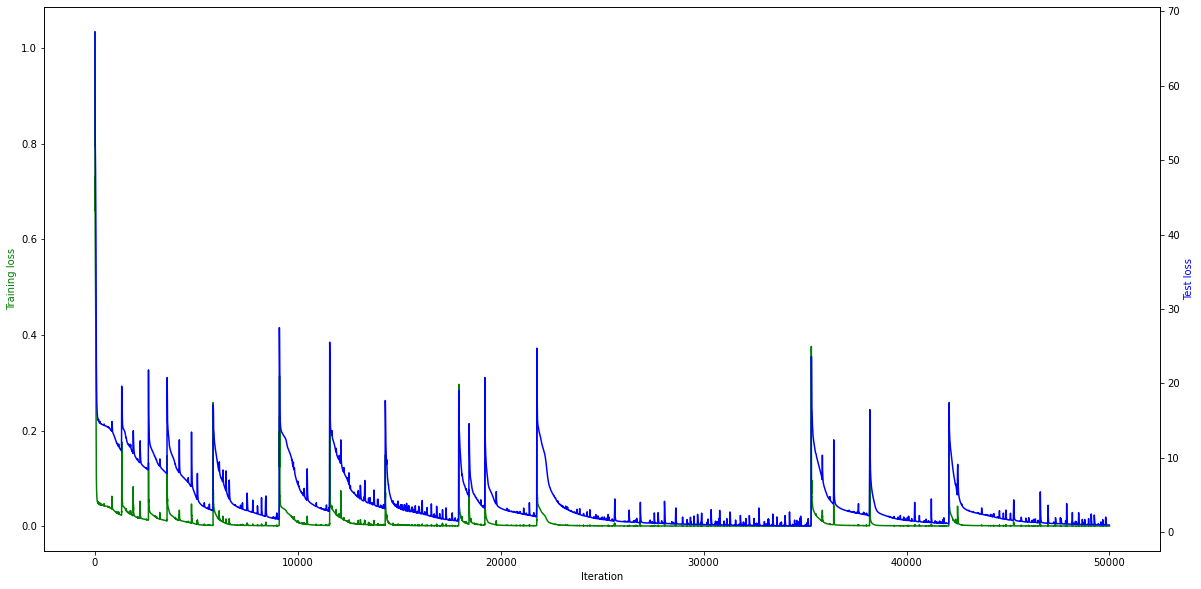

In [22]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(np.arange(len(list_training_loss)), list_training_loss, 'g-')
ax2.plot(np.arange(len(list_test_pred_error))*num_iter_test, list_test_pred_error, 'b-')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training loss', color='g')
ax2.set_ylabel('Test loss', color='b')

best_iter = (np.where(np.asarray(list_training_loss)==np.min(list_training_loss))[0][0]//num_iter_test)*num_iter_test
best_pred_error = list_test_pred_error[best_iter//num_iter_test]
print ('Best predictions at iter: %d (error: %f)' % (best_iter, best_pred_error))
RMSE = np.sqrt(np.square(best_pred_error)/np.sum(Otest))
print ('RMSE: %f' % RMSE)

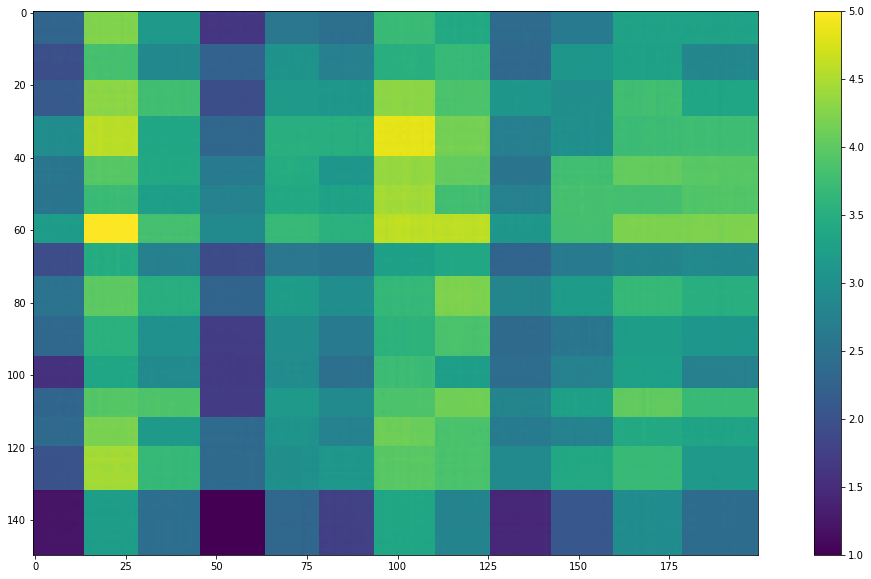

In [23]:
#best X generated
plt.figure(figsize=(20,10))
plt.imshow(list_X[best_iter//num_iter_test])
plt.colorbar()